In [17]:
%matplotlib inline

#Here we set the dimensions for the figures in this notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import numpy as np
import h5py
import pandas as pd
import math
import seaborn as sns
from collections import OrderedDict
from scipy.stats import fisher_exact
import math
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict, OrderedDict
import mygene
from BCBio import GFF
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation

In [95]:
def get_lncRNAs():
    in_file = "../all_marks/gencode.v31.long_noncoding_RNAs.gff3"
    in_handle = open(in_file)

    limit_info = dict(
        gff_id = ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 
        'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX', 'chrY'],
        gff_type = ["gene"])

    lncRNAgenes = []
    for rec in GFF.parse(in_handle, limit_info=limit_info):
        lncRNAgenes.append((rec.id, rec.features)) 

    in_handle.close()
    
    return {g.id.split(".")[0]: i for i, j in lncRNAgenes for g in j}

In [97]:
lncRNA_chrs = get_lncRNAs()

In [49]:
targets = [("H3K27ac", "_narrow"), ("H3K36me3", ""), 
       lncRNA_chrs    ("H3K4me1", "_narrow"), ("H3K4me2", "_narrow"), ("H3K4me3", "_narrow"), ("H3K79me2", ""), 
           ("H3K9ac", "_narrow"), ("H3K9me3", ""), ("H4K20me1", ""), ("H3K27me3", ""), ("methylation", "")]

In [19]:
chrom_lengths = OrderedDict({'chr1':248956422,
'chr2':242193529,
'chr3':198295559,
'chr4':190214555,
'chr5':181538259,
'chr6':170805979,
'chr7':159345973,
'chr8':145138636,
'chr9':138394717,
'chr10':133797422,
'chr11':135086622,
'chr12':133275309,
'chr13':114364328,
'chr14':107043718,
'chr15':101991189,
'chr16':90338345,
'chr17':83257441,
'chr18':80373285,
'chr19':58617616,
'chr20':64444167,
'chr21':46709983,
'chr22':50818468,
'chrX':156040895,
'chrY':57227415})

In [13]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in [0.0,0.33,0.67,0.90]]
from matplotlib.colors import hex2color
colors = ['#1b9e77', "#d95f02", '#7570b3', '#e7298a']
# Converting from HEX into RGB\n",
colors = [hex2color(colors[i]) for i in range(len(colors))]

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
#==========================================Идем по всем меткам и РНКам в ней========================================================

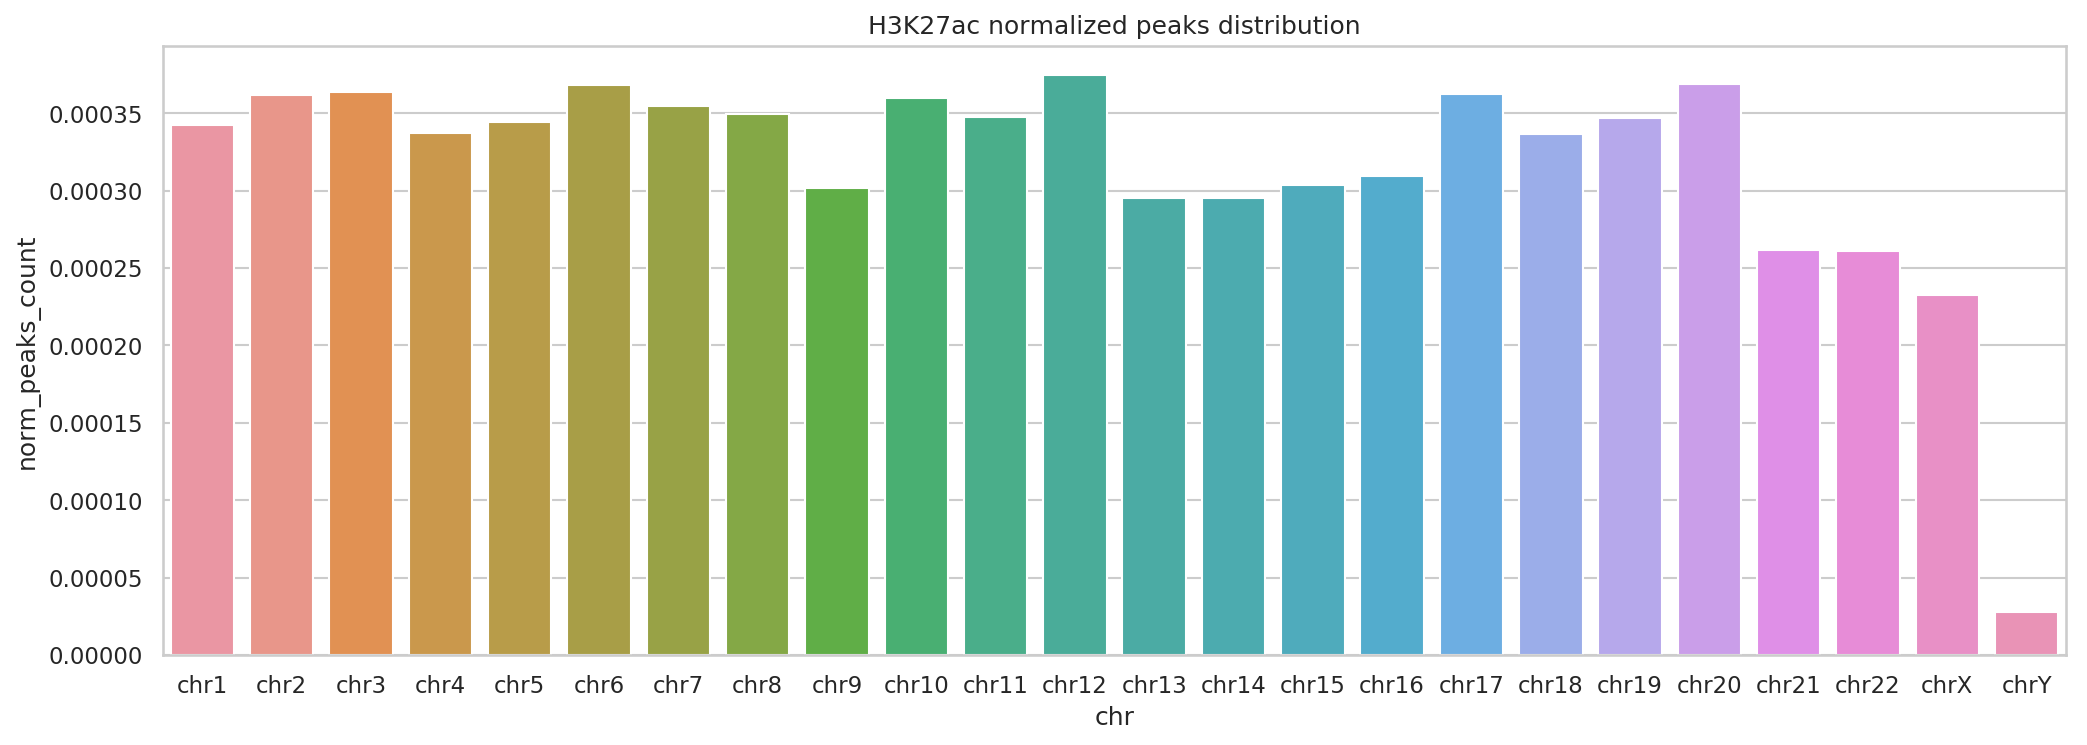

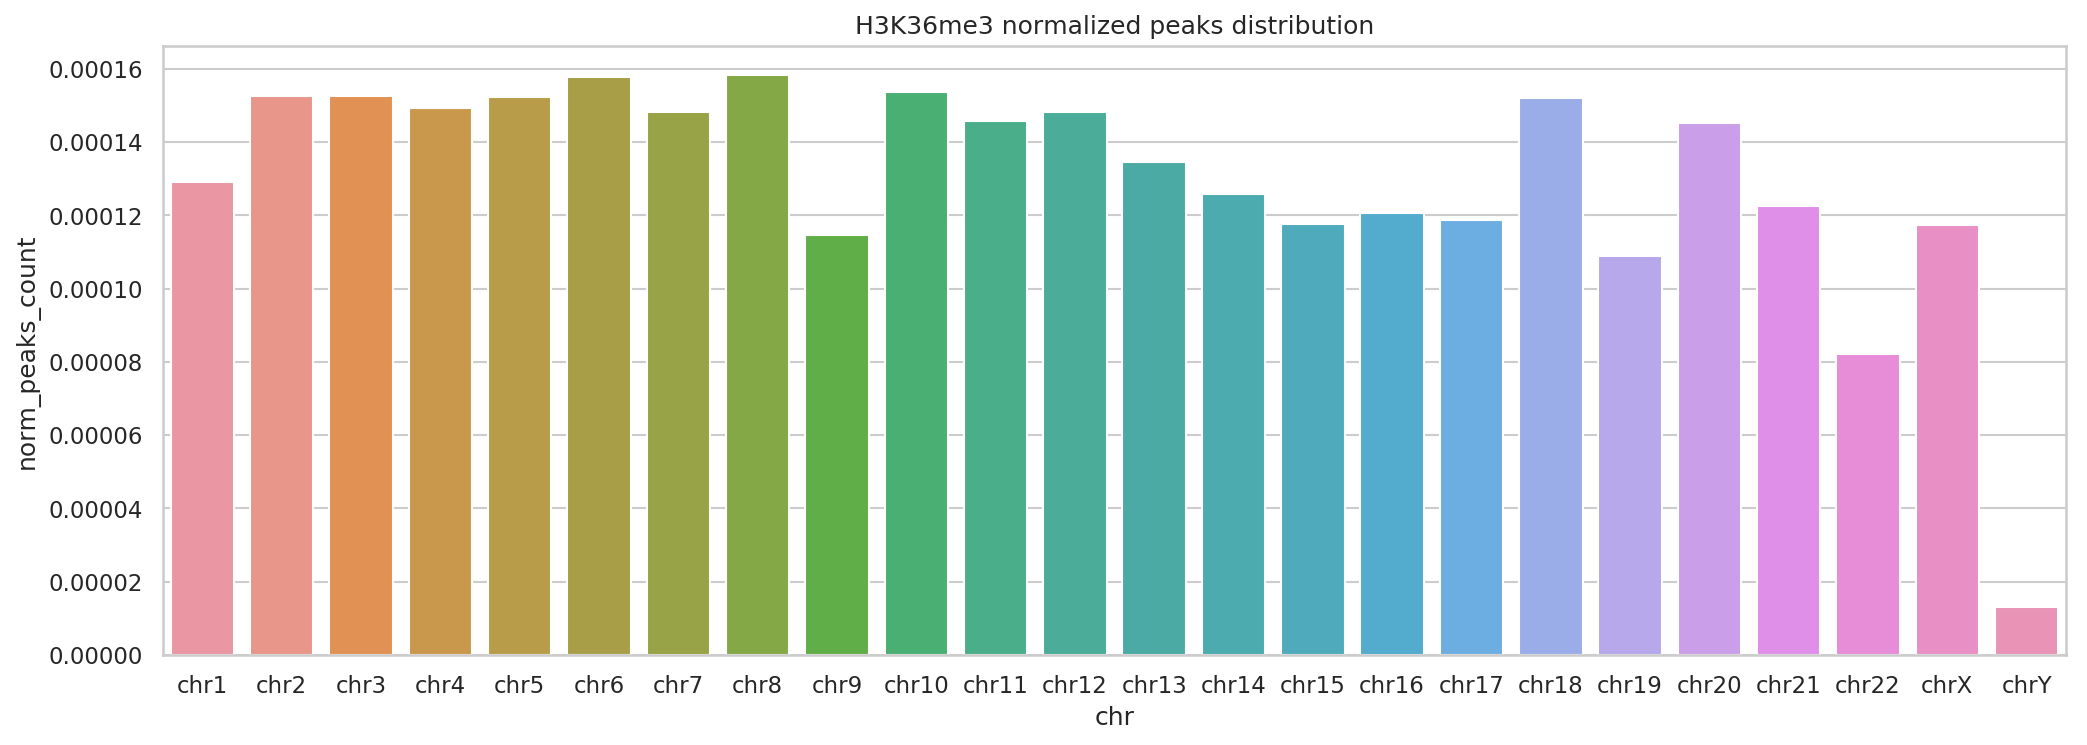

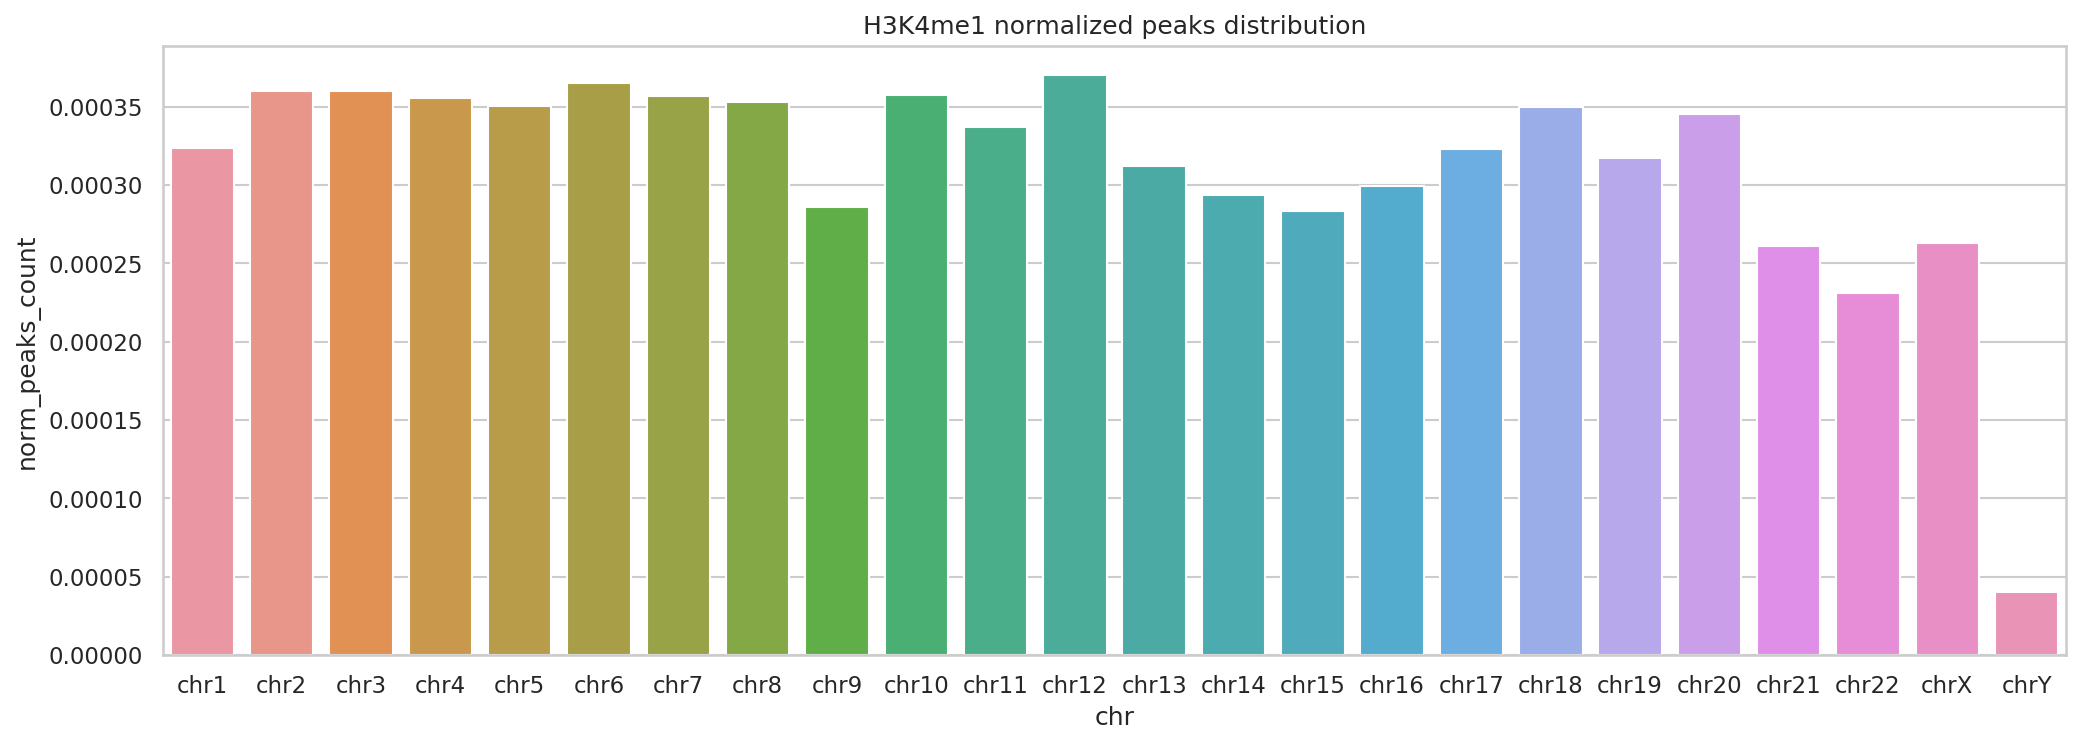

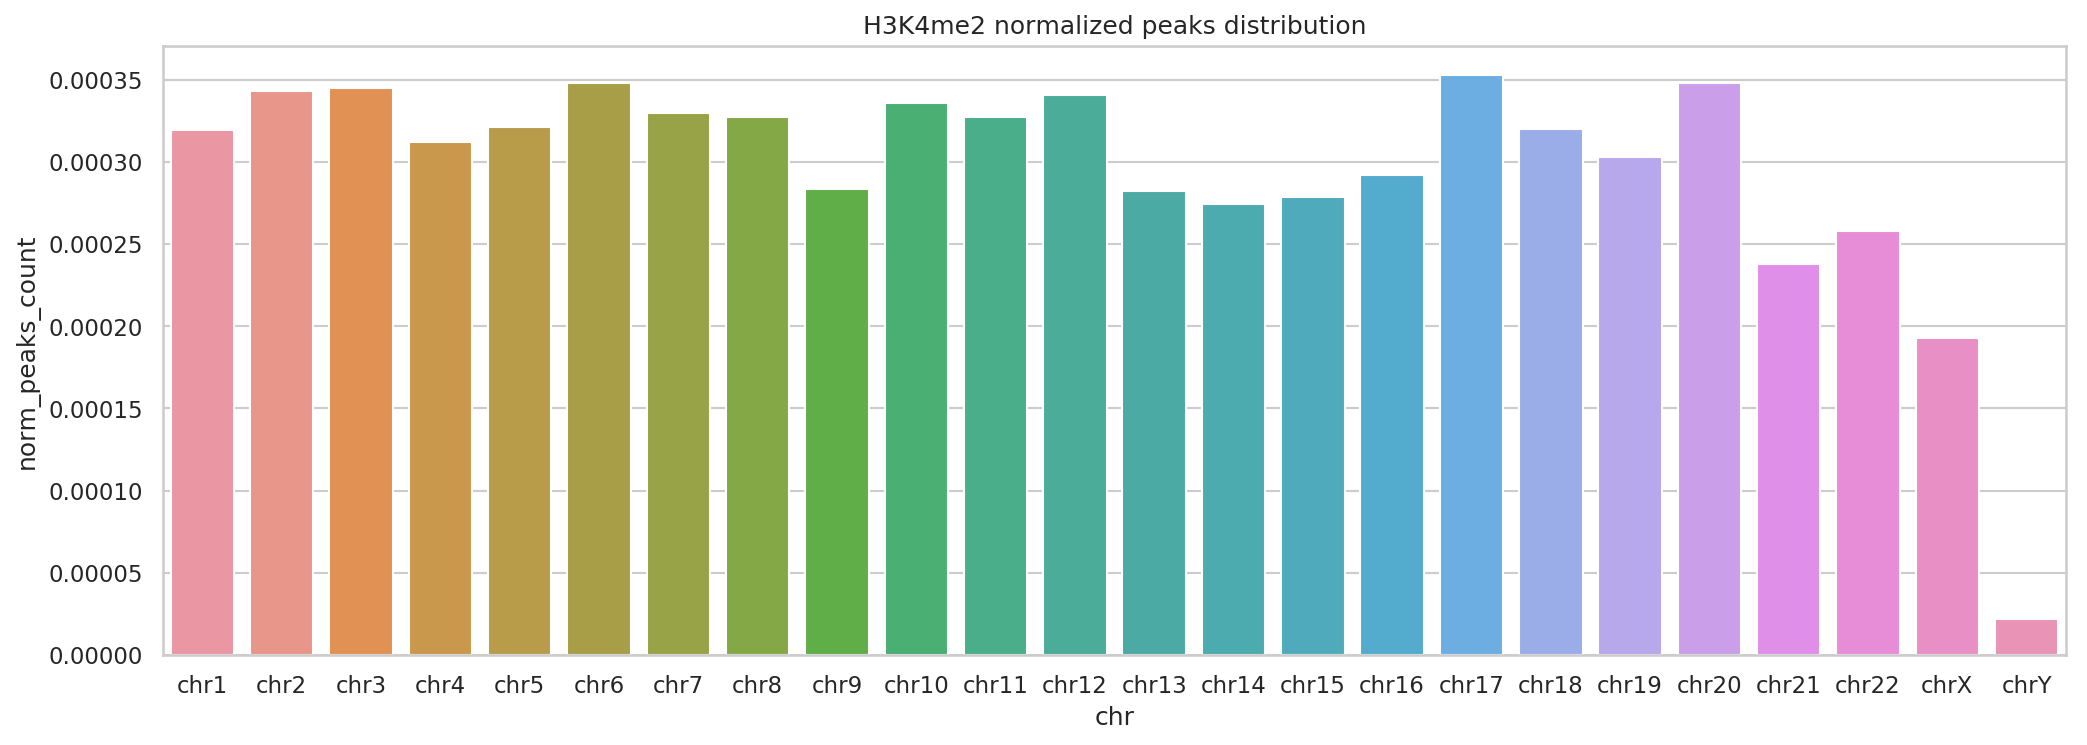

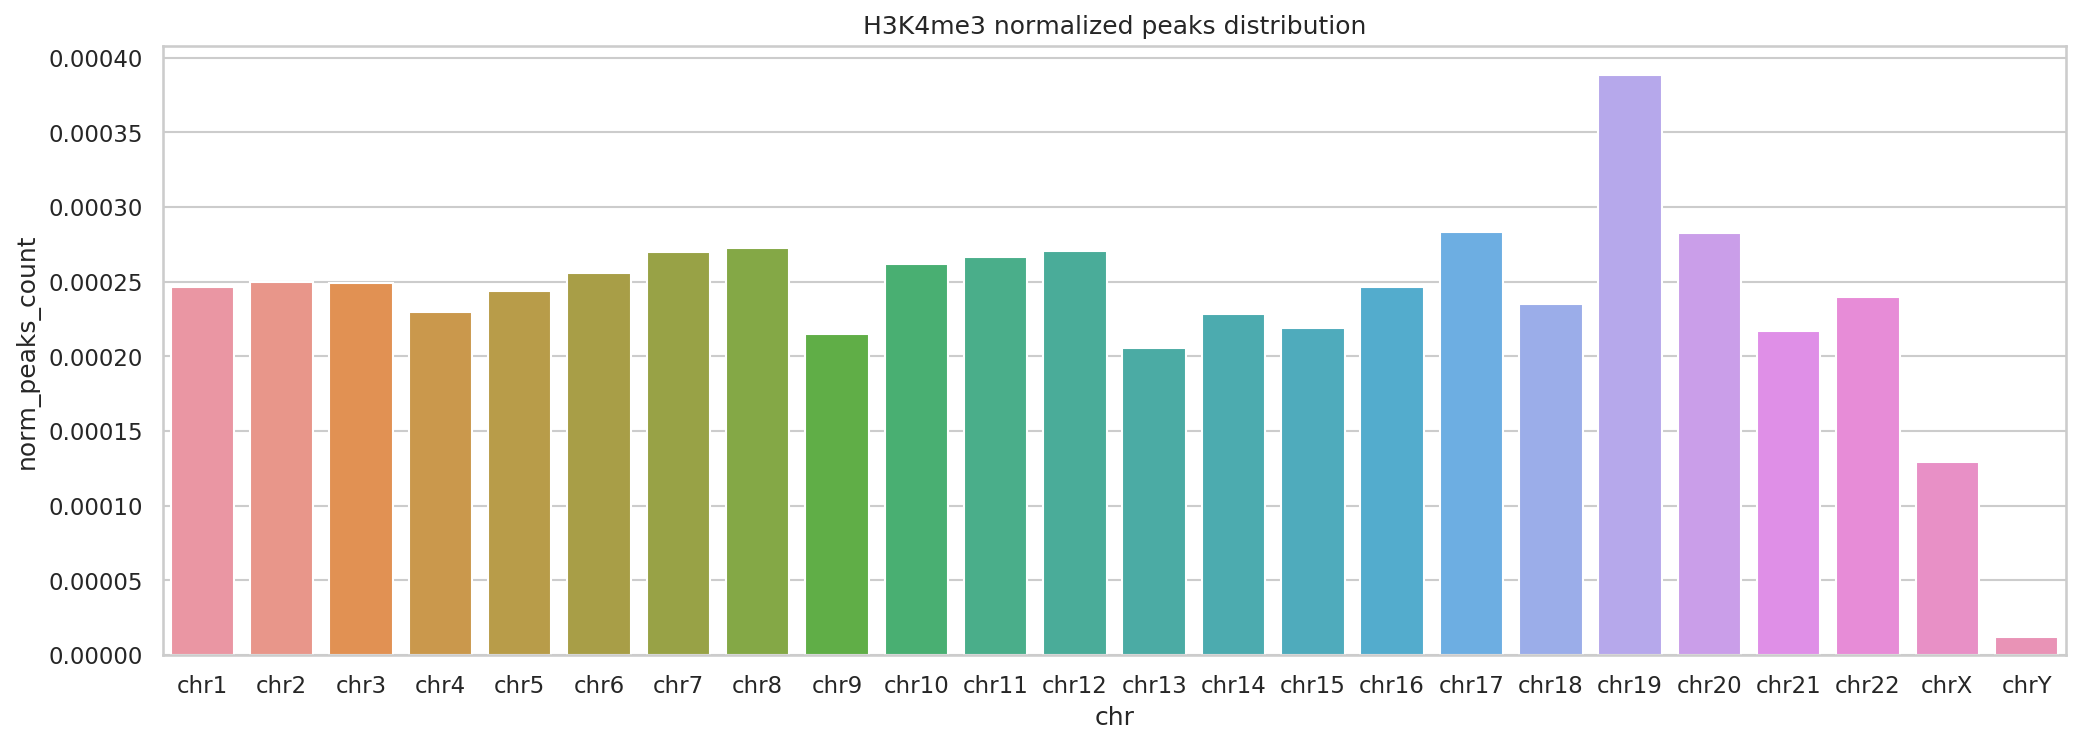

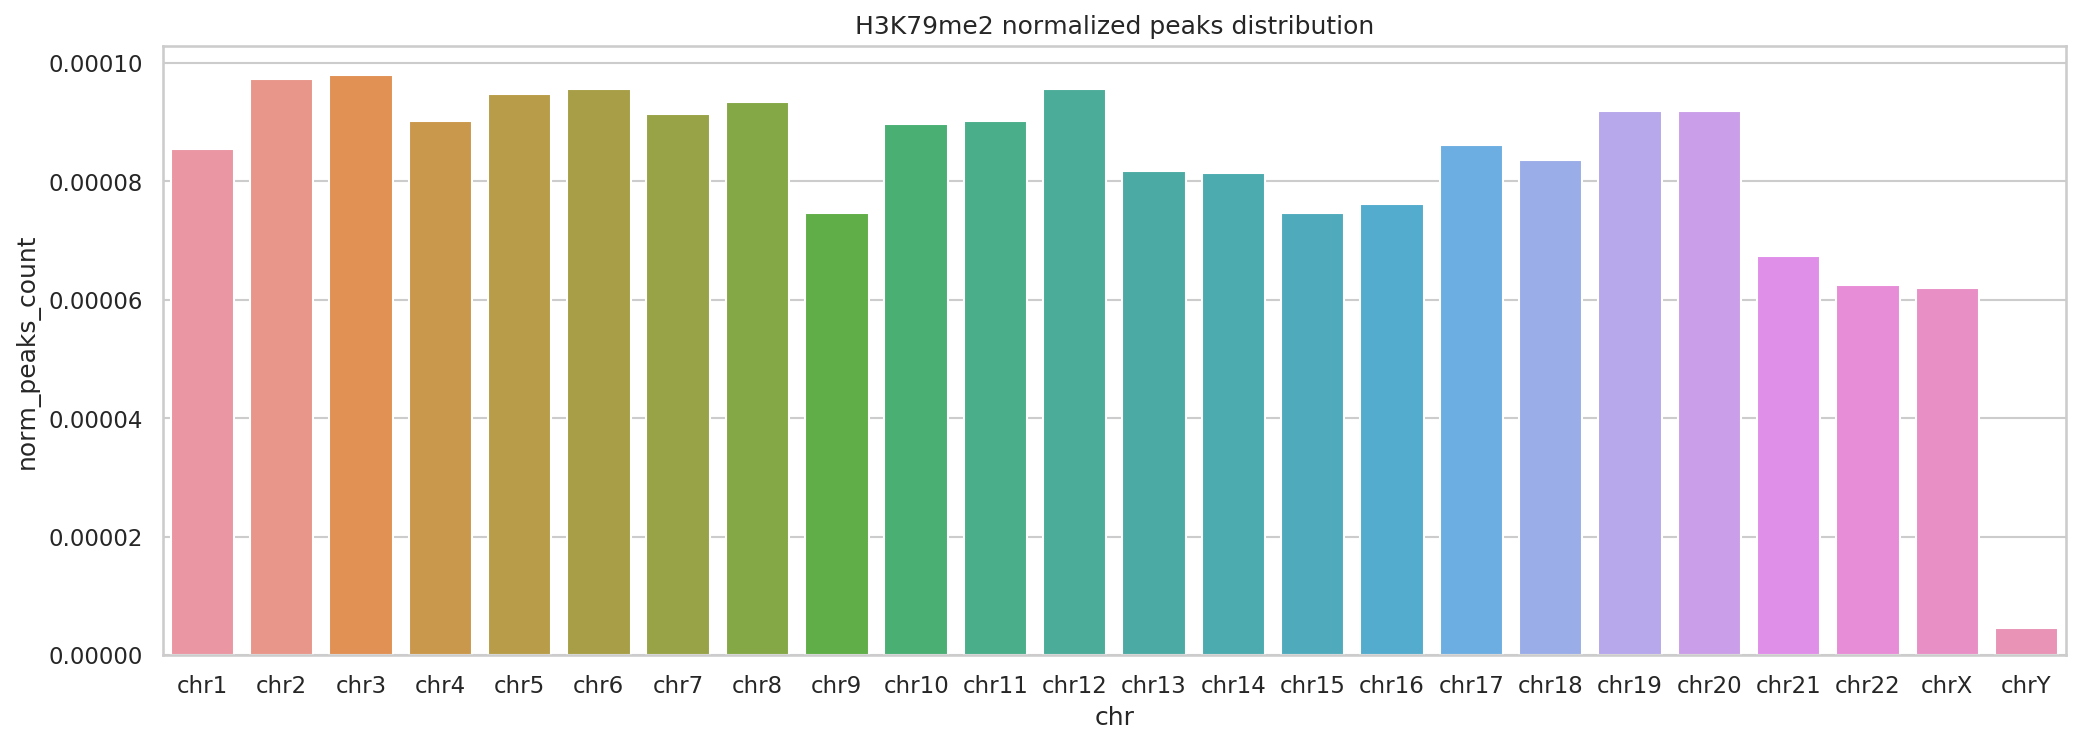

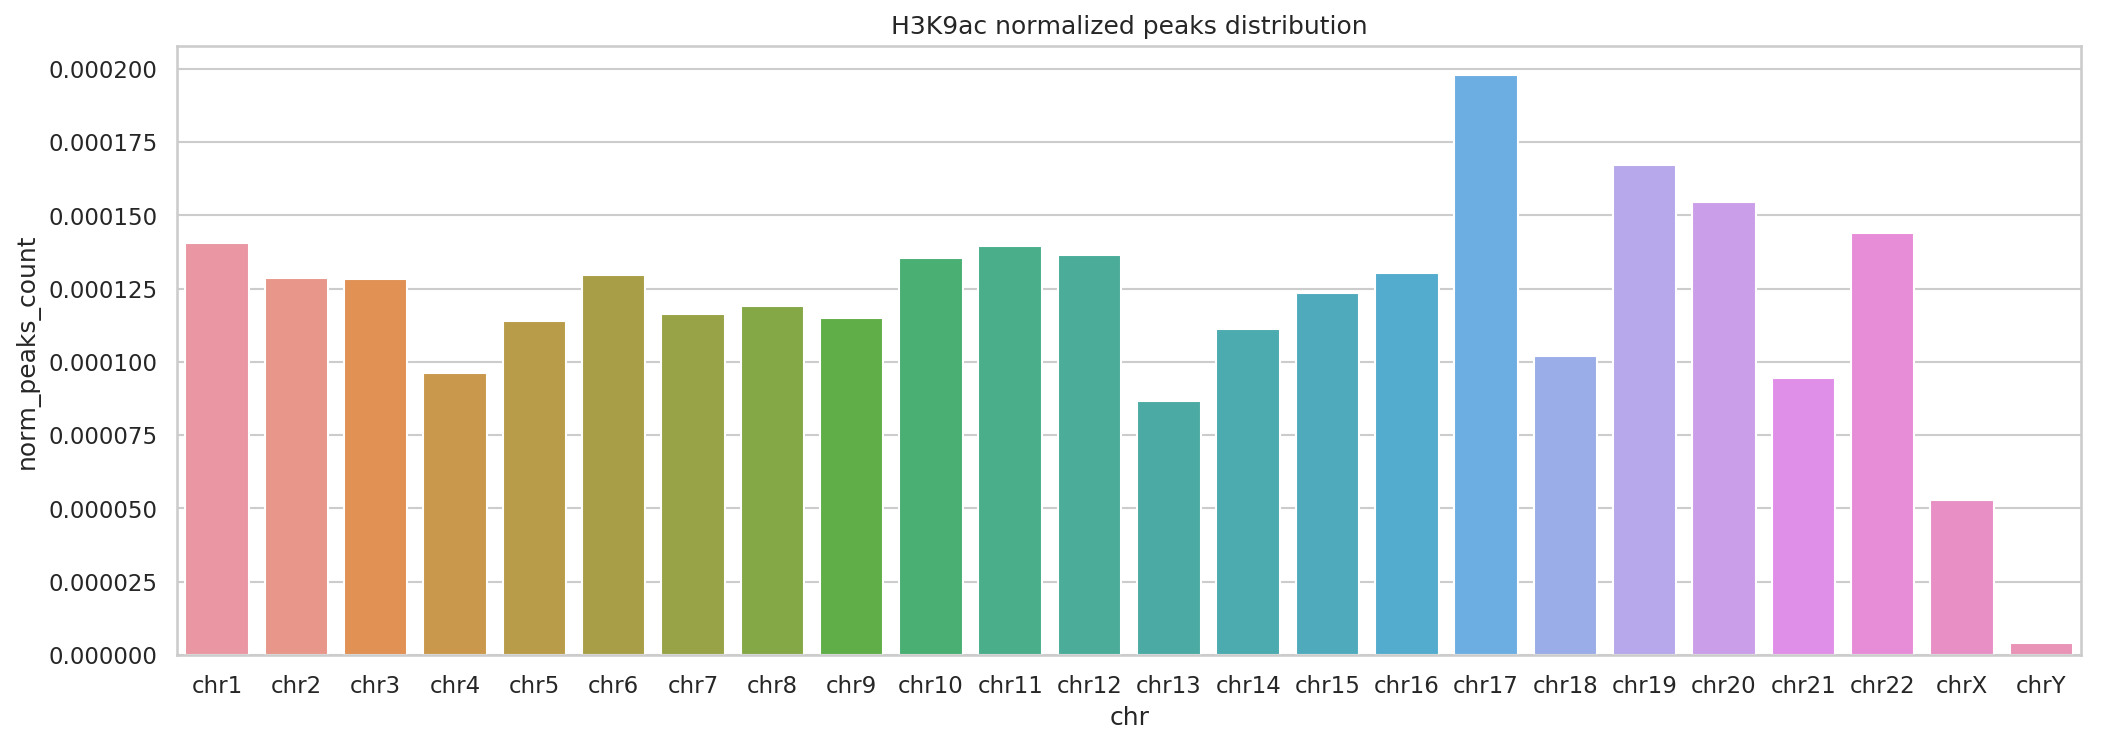

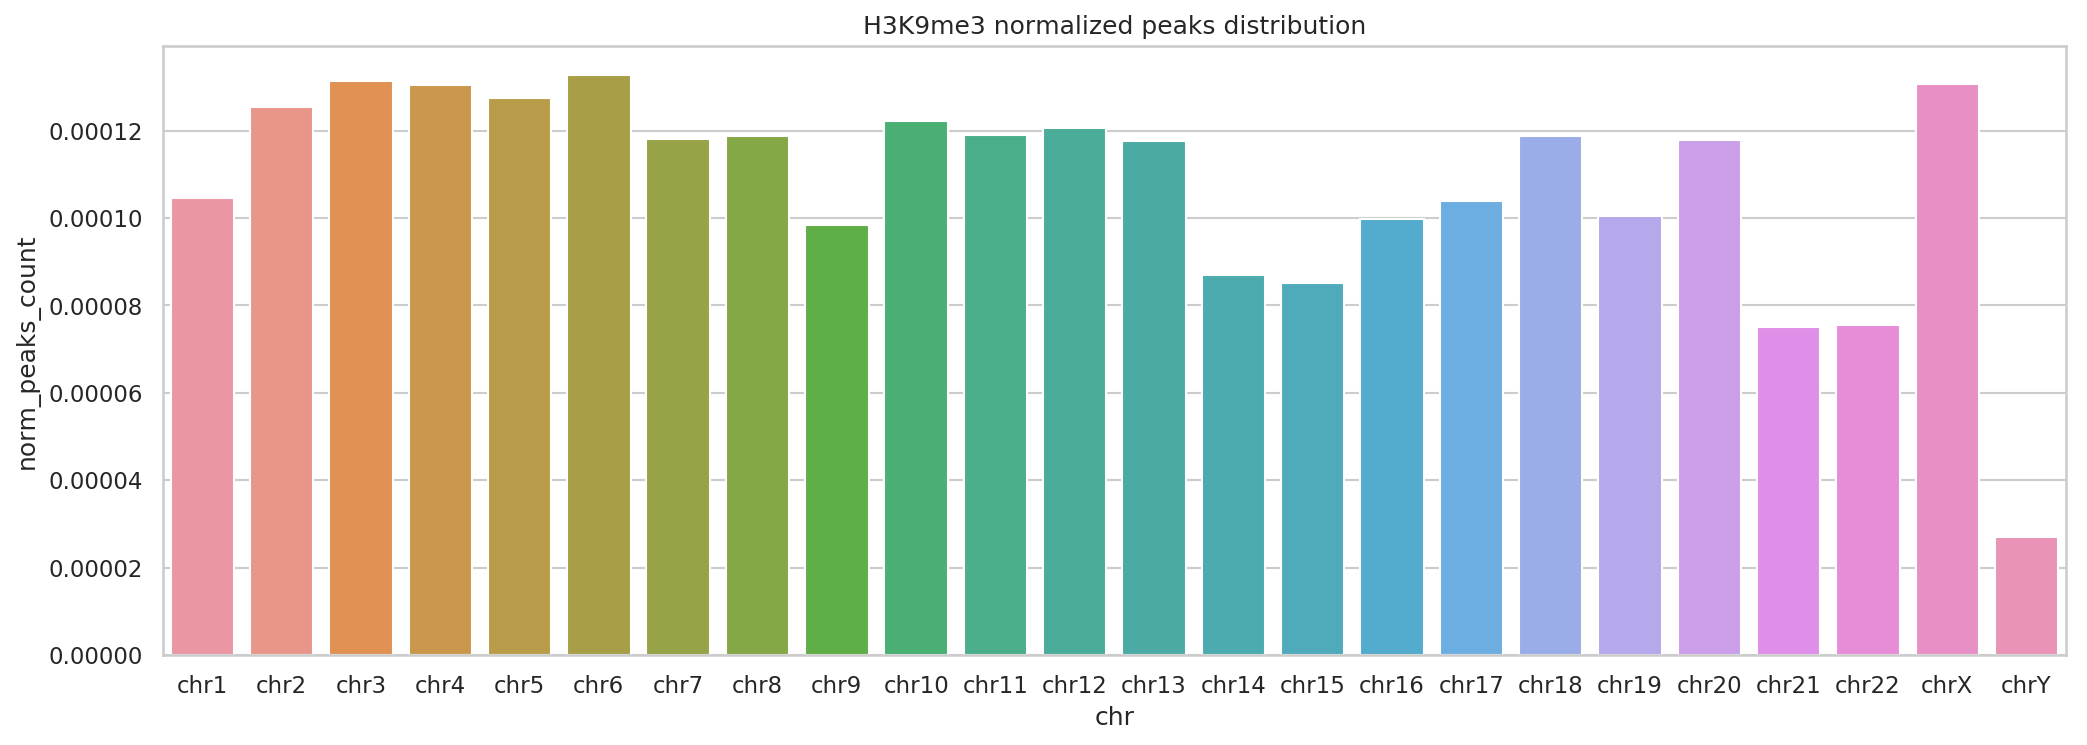

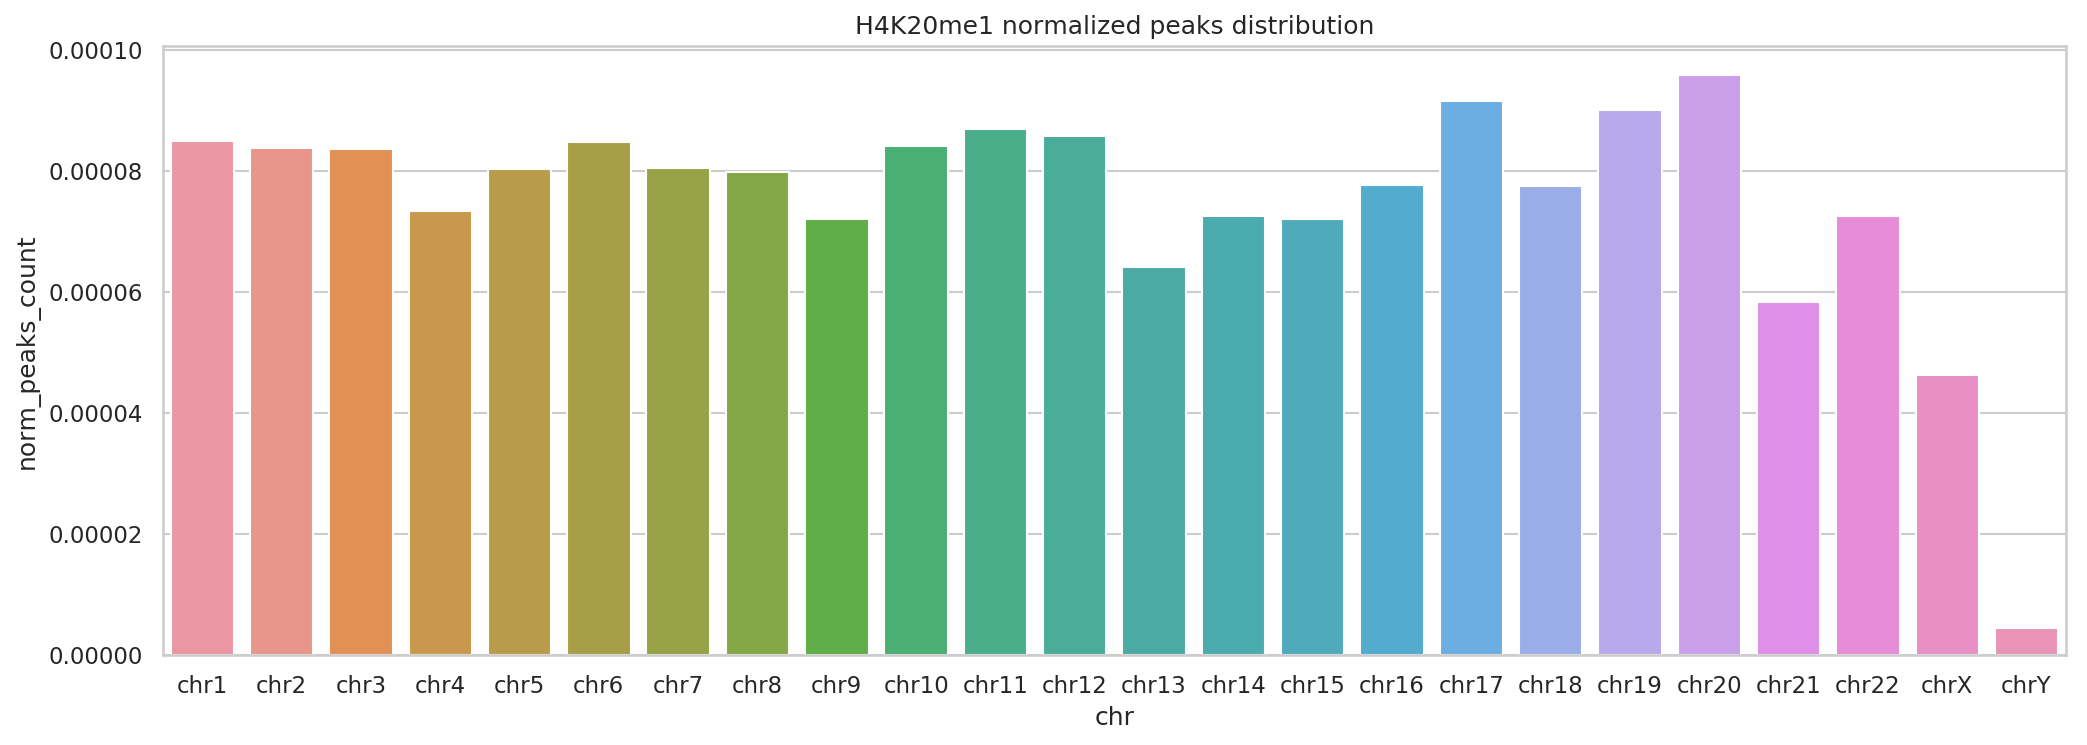

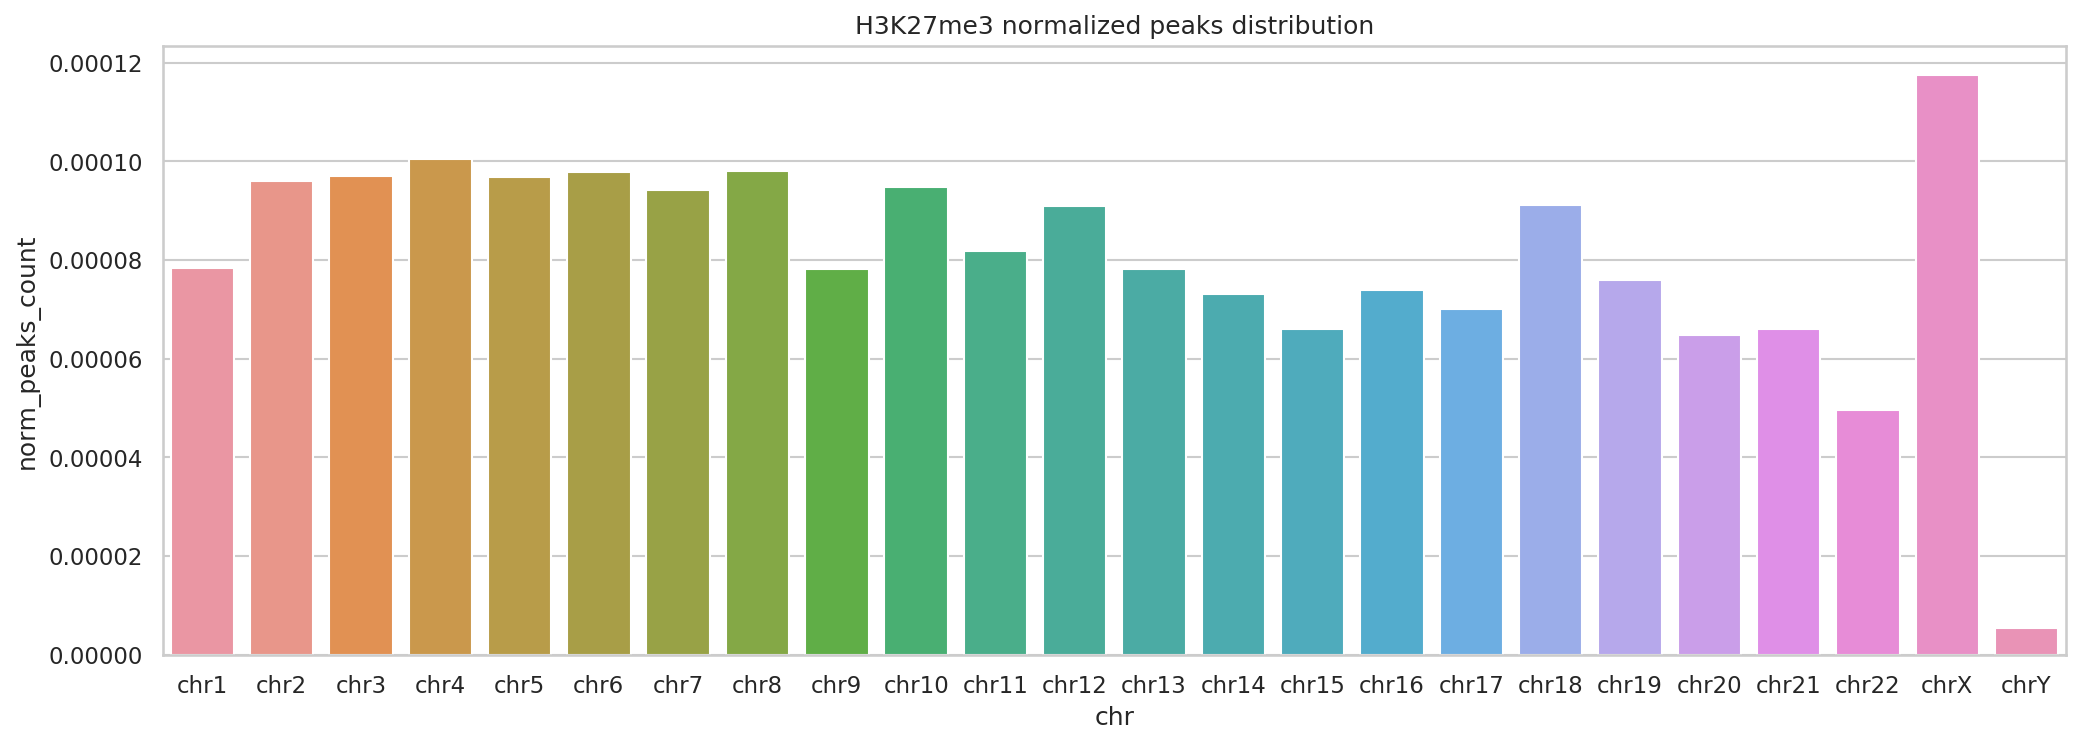

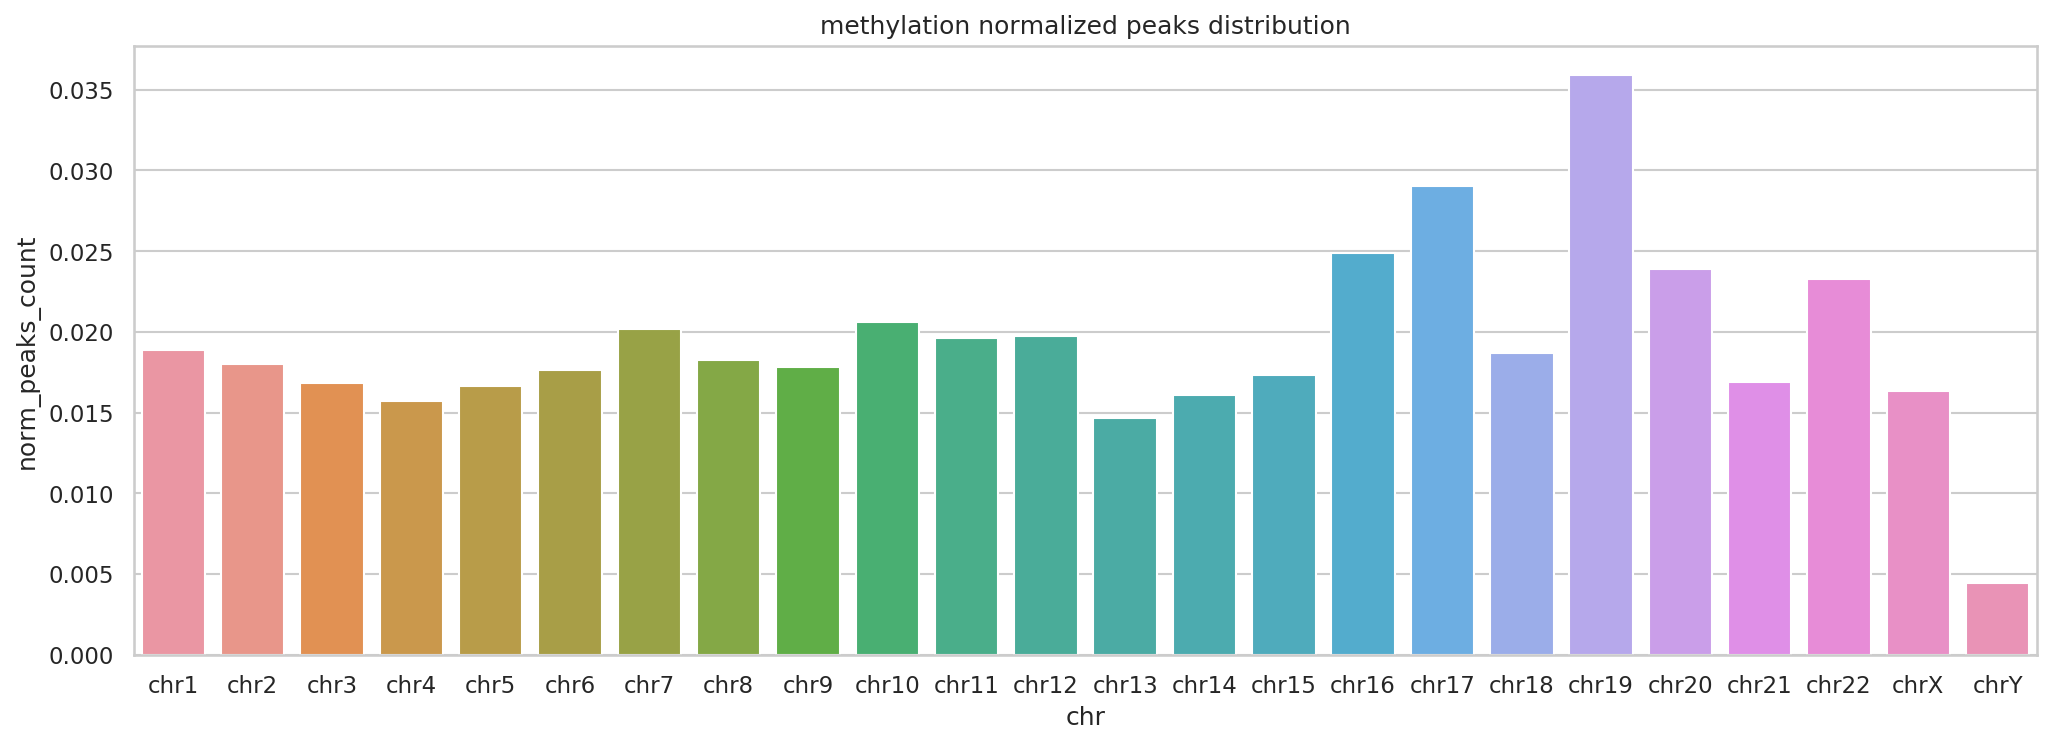

In [52]:
# TODO: а что если построить на одном графике стек барплоты для всех меток? без нормализации
# Посмотреть на H3K27me3 и X хромосому
# Сравнить распределения пиков? Типа, в H3K9me3 и в H3K27me3 больше всего пиков в X хромосоме по сравнению с другими метками
# Нормализовать к средней длине хромосом
peaks_over_chroms = {}
for target in targets:
    peaks = pd.read_csv("../all_marks/" + target[0] + "/merged_peaks_first_in_biosample.bed", sep="\t", header=None)
    peaks = peaks[peaks[0].isin(['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY'])]
    peaks_by_chrs = peaks.groupby([0]).count().sort_values([0], ascending=False)
    peaks_count = pd.DataFrame({"chr": peaks_by_chrs.index, 'peaks_count': peaks_by_chrs[1].tolist()}, index=[sort_chroms(c) for c in peaks_by_chrs.index])
    peaks_count = peaks_count.sort_index()
    peaks_count['norm_peaks_count'] = peaks_count['peaks_count'].divide(list(chrom_lengths.values()), axis=0)
    peaks_over_chroms[target[0]] = peaks_count
    
    plt.figure()
    sns.set(style="whitegrid")
    ax = sns.barplot(x="chr", y="norm_peaks_count", data=peaks_count).set_title(target[0] + " normalized peaks distribution")

In [ ]:
#===============================ищем особенные хромосомы для каждой нкРНК с помощью теста Фишера ==================================

In [106]:
targets = [("H3K27ac", "_narrow"), ("H3K36me3", ""), 
           ("H3K4me1", "_narrow"), ("H3K4me2", "_narrow"), ("H3K4me3", "_narrow"), ("H3K79me2", ""), 
           ("H3K9ac", "_narrow"), ("H3K9me3", ""), ("H4K20me1", ""), ("H3K27me3", "")]

In [107]:
localization = {}
for target in targets:
    print(target[0])
    all_peaks = pd.read_csv("../all_marks/" + target[0] + "/merged_peaks_first_in_biosample.bed", sep="\t", header=None)
    if(target[0] == 'methylation'):
        for i in range(0, 19):
            with h5py.File("../all_marks/" + target[0] + "/lncRNA_Peaks_corrs/lncRNA_Peaks_Correlations_corrected_non_zero_" + str(i) + ".hdf5", 'r') as f:
                lncRNAs = list(f['lncRNAs_names'][:])
                for j, gene_id in enumerate(lncRNAs):
                    print("i = " + str(i) + ", j = " + str(j))
                    corr = f['corrs_matrix'][lncRNAs.index(gene_id), :]
                    res.update(fisher_by_rna(gene_id, corr, all_peaks))
                    
        localization[target[0]] = res
    else:
        with h5py.File("../all_marks/" + target[0] + "/lncRNA_Peaks_corrs/lncRNA_Peaks_Correlations_corrected_non_zero.hdf5", 'r') as f:
            lncRNAs = list(f['lncRNAs_names'][:])
            res = {}
            for i, gene_id in enumerate(lncRNAs):
                print(i)
                corr = f['corrs_matrix'][lncRNAs.index(gene_id), :]
                tmp = fisher_by_rna(gene_id, corr, all_peaks)
                if tmp:
                    res.update(tmp)
        
        if res:
            localization[target[0]] = res

H3K27ac
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
querying 1-1...done.
Finished.
1 input query terms found dup hits:
	[('ENSG00000172965', 2)]
defaultdict(<class 'list'>, {'ENSG00000172965': [('-', 'MIR4435-2HG', {'chr19': (1447, (2.082703986051069, 2.6227587299400534e-127))})]})
17
18
19
20
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
querying 1-1...done.
Finished.
defaultdict(<class 'list'>, {'ENSG000

1213
1214
1215
1216
1217
1218
1219
1220
querying 1-1...done.
Finished.
defaultdict(<class 'list'>, {'ENSG00000262370': [('+', 'AC108134.3', {'chr19': (2044, (3.3844409490754725, 0.0))})]})
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
querying 1-1...done.
Finished.
defaultdict(<class 'list'>, {'ENSG00000267107': [('+', 'PCAT19', {'chr19': (1959, (3.3372616270304487, 0.0))})]})
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
querying 1-1...done.
Finished.
defaultdict(<class 'list'>, {'ENSG00000267702': [('+', 'AP005131.6', {

547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
querying 1-1...done.
Finished.
defaultdict(<class 'list'>, {'ENSG00000258498': [('+', 'DIO3OS', {'chr19': (1056, (2.4676920118249024, 5.488065097301635e-127))})]})
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
querying 1-1...done.
Finished.
defaultdict(<class 'list'>, {'ENSG00000260772': [('+', 'AC012321.1', {'chr19': (1

610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
querying 1-1...done.
Finished.
defaultdict(<class 'list'>, {'ENSG00000247774': [('+', 'PCED1B-AS1', {'chr19': (1567, (5.304411177548982, 0.0))})]})
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
querying 1-1...done.
Finished.
defaultdict(<class 'list'>, {'ENSG00000248441': [('+', 'LINC01197', {'chr19': (2205, (2.2856084863052772, 4.512957170838101e-231)), 'chr22': (1352, (2.18916242045939, 3.804501275005807e-131))})]})
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
querying 1-1...done.
Finished.
defaultdict(<

1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
querying 1-1...done.
Finished.
defaultdict(<class 'list'>, {'ENSG00000279377': [('+', 'AC003973.2', {'chr19': (1101, (3.936124014488165, 6.173476486078642e-284))})]})
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
querying 1-1...done.
Finished.
defaultdict(<class 'list'>, {'ENSG00000279711': [('+', 'AP004782.1', {'chrX': (1681, (2.4189373627494377, 3.2222822441734042e-202))})]})
1811
1812
1813
1814
1815
1816
1817
1818
1819
querying 1-1...done.
Finished.
defaultdict(<class 'list'>, {'ENSG00000279805': [('+', 'Z95114.3', {'chr19': (1007, (3.6249839842704406, 1.7765500064565064e-235))})]})
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
183

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
#график с каких хромосом наши нкРНК

In [110]:
chroms = OrderedDict({"+chr1": 0, "-chr1": 0, "+chr2": 0, "-chr2": 0, "+chr3": 0, "-chr3": 0, "+chr4": 0, "-chr4": 0, 
                      "+chr5": 0, "-chr5": 0, "+chr6": 0, "-chr6": 0, "+chr7": 0, "-chr7": 0, "+chr8": 0, "-chr8": 0, 
                      "+chr9": 0, "-chr9": 0, "+chr10": 0, "-chr10": 0, "+chr11": 0, "-chr11": 0, "+chr12": 0, "-chr12": 0, 
                      "+chr13": 0, "-chr13": 0, "+chr14": 0, "-chr14": 0, "+chr15": 0, "-chr15": 0, "+chr16": 0, "-chr16": 0, 
                      "+chr17": 0, "-chr17": 0, "+chr18": 0, "-chr18": 0, "+chr19": 0, "-chr19": 0, "+chr20": 0, "-chr20": 0, 
                        "+chr21": 0, "-chr21": 0, "+chr22": 0, "-chr22": 0, "+chrX": 0, "-chrX": 0, "+chrY": 0, "-chrY": 0})

H3K27ac
H3K27ac ENSG00000172965 MIR4435-2HG ../all_marks/plots/distributions/H3K27ac/MIR4435-2HG_(chr2).png
H3K27ac ENSG00000175061 SNHG29 ../all_marks/plots/distributions/H3K27ac/SNHG29_(chr17).png
H3K27ac ENSG00000175147 TMEM51-AS1 ../all_marks/plots/distributions/H3K27ac/TMEM51-AS1_(chr1).png
H3K27ac ENSG00000196167 COLCA1 ../all_marks/plots/distributions/H3K27ac/COLCA1_(chr11).png
H3K27ac ENSG00000212978 AC016747.1 ../all_marks/plots/distributions/H3K27ac/AC016747.1_(chr2).png
H3K27ac ENSG00000230091 TMEM254-AS1 ../all_marks/plots/distributions/H3K27ac/TMEM254-AS1_(chr10).png
H3K27ac ENSG00000230910 AL391807.1 ../all_marks/plots/distributions/H3K27ac/AL391807.1_(chr6).png
H3K27ac ENSG00000233038 AC011899.2 ../all_marks/plots/distributions/H3K27ac/AC011899.2_(chr7).png
H3K27ac ENSG00000235111 Z97192.3 ../all_marks/plots/distributions/H3K27ac/Z97192.3_(chr22).png
H3K27ac ENSG00000239911 PRKAG2-AS1 ../all_marks/plots/distributions/H3K27ac/PRKAG2-AS1_(chr7).png
H3K27ac ENSG00000242686 

H3K4me3 ENSG00000235437 LINC01278 ../all_marks/plots/distributions/H3K4me3/LINC01278_(chrX).png
H3K4me3 ENSG00000236671 PRKG1-AS1 ../all_marks/plots/distributions/H3K4me3/PRKG1-AS1_(chr10).png
H3K4me3 ENSG00000242588 AC108010.1 ../all_marks/plots/distributions/H3K4me3/AC108010.1_(chr7).png
H3K4me3 ENSG00000250334 LINC00989 ../all_marks/plots/distributions/H3K4me3/LINC00989_(chr4).png
H3K4me3 ENSG00000254639 AC116021.1 ../all_marks/plots/distributions/H3K4me3/AC116021.1_(chr11).png
H3K4me3 ENSG00000255345 AP002957.1 ../all_marks/plots/distributions/H3K4me3/AP002957.1_(chr11).png
H3K4me3 ENSG00000259134 LINC00924 ../all_marks/plots/distributions/H3K4me3/LINC00924_(chr15).png
H3K4me3 ENSG00000259438 MAPK6-DT ../all_marks/plots/distributions/H3K4me3/MAPK6-DT_(chr15).png
H3K4me3 ENSG00000259705 AC084757.3 ../all_marks/plots/distributions/H3K4me3/AC084757.3_(chr15).png
H3K4me3 ENSG00000260711 AL121839.2 ../all_marks/plots/distributions/H3K4me3/AL121839.2_(chr14).png
H3K4me3 ENSG00000260772 A

H3K27me3 ENSG00000267107 PCAT19 ../all_marks/plots/distributions/H3K27me3/PCAT19_(chr19).png
H3K27me3 ENSG00000267272 LINC01140 ../all_marks/plots/distributions/H3K27me3/LINC01140_(chr1).png
H3K27me3 ENSG00000267506 AC021683.2 ../all_marks/plots/distributions/H3K27me3/AC021683.2_(chr17).png
H3K27me3 ENSG00000267702 AP005131.6 ../all_marks/plots/distributions/H3K27me3/AP005131.6_(chr18).png
H3K27me3 ENSG00000267731 AC005332.2 ../all_marks/plots/distributions/H3K27me3/AC005332.2_(chr17).png
H3K27me3 ENSG00000268170 AC073342.2 ../all_marks/plots/distributions/H3K27me3/AC073342.2_(chr7).png
H3K27me3 ENSG00000268734 AC245128.3 ../all_marks/plots/distributions/H3K27me3/AC245128.3_(chr19).png
H3K27me3 ENSG00000270127 AC027020.2 ../all_marks/plots/distributions/H3K27me3/AC027020.2_(chr15).png
H3K27me3 ENSG00000270194 AC097359.2 ../all_marks/plots/distributions/H3K27me3/AC097359.2_(chr3).png
H3K27me3 ENSG00000270641 TSIX ../all_marks/plots/distributions/H3K27me3/TSIX_(chrX).png
H3K27me3 ENSG000

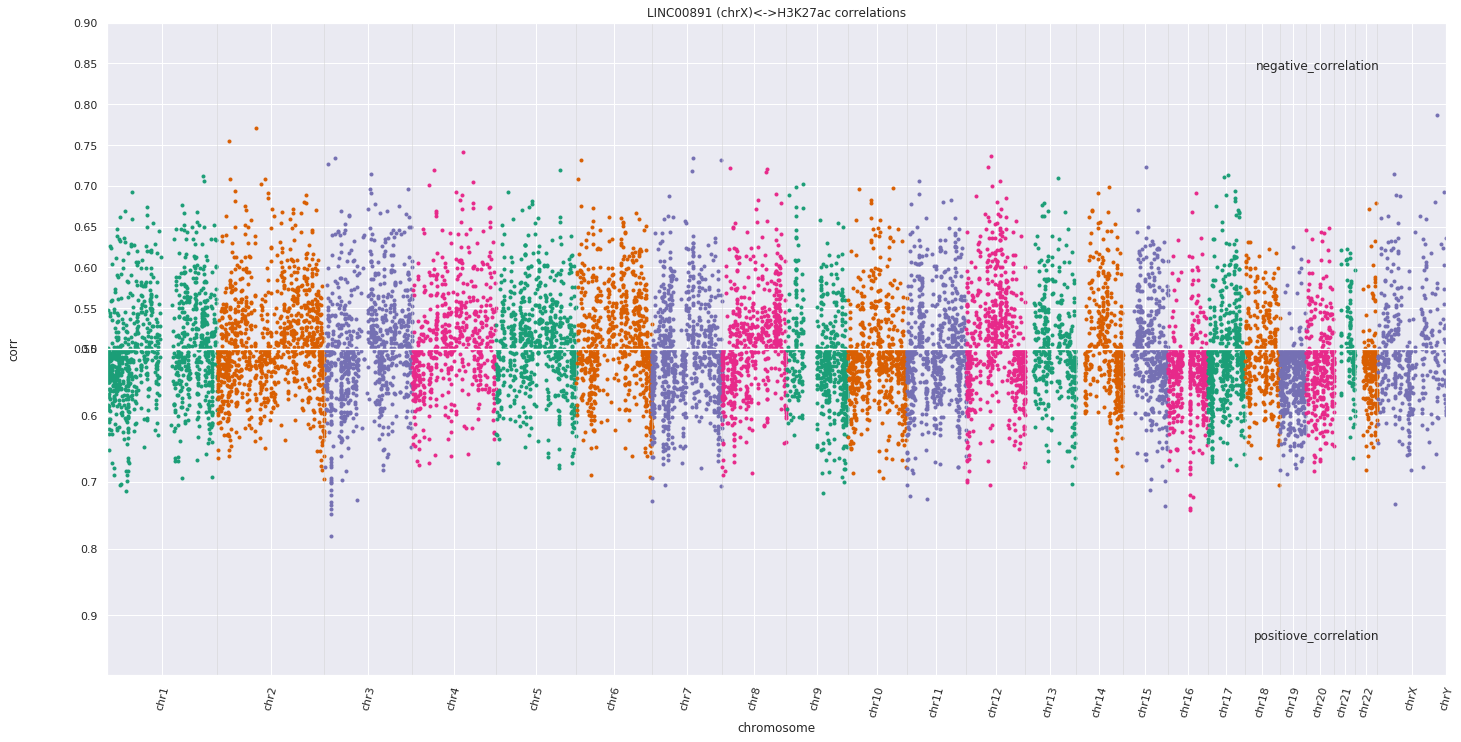

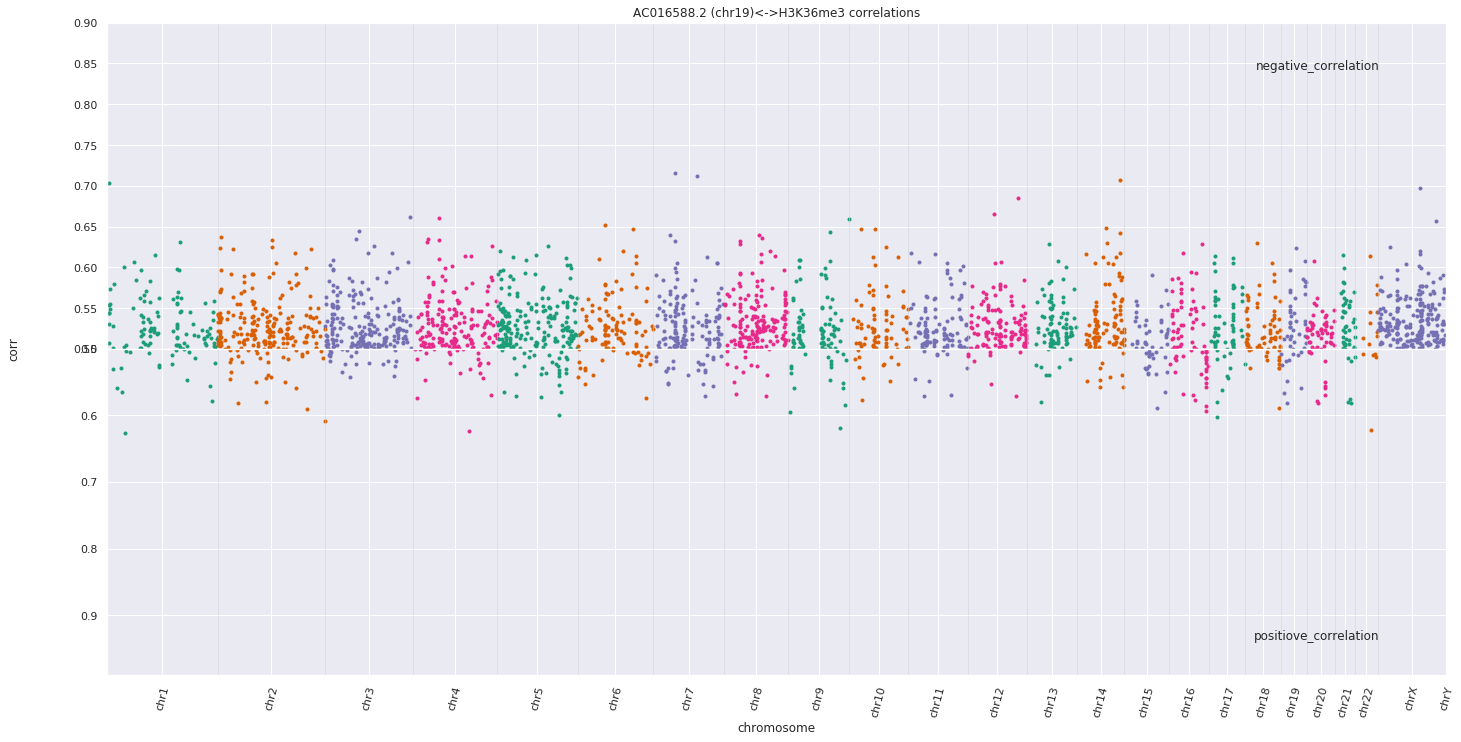

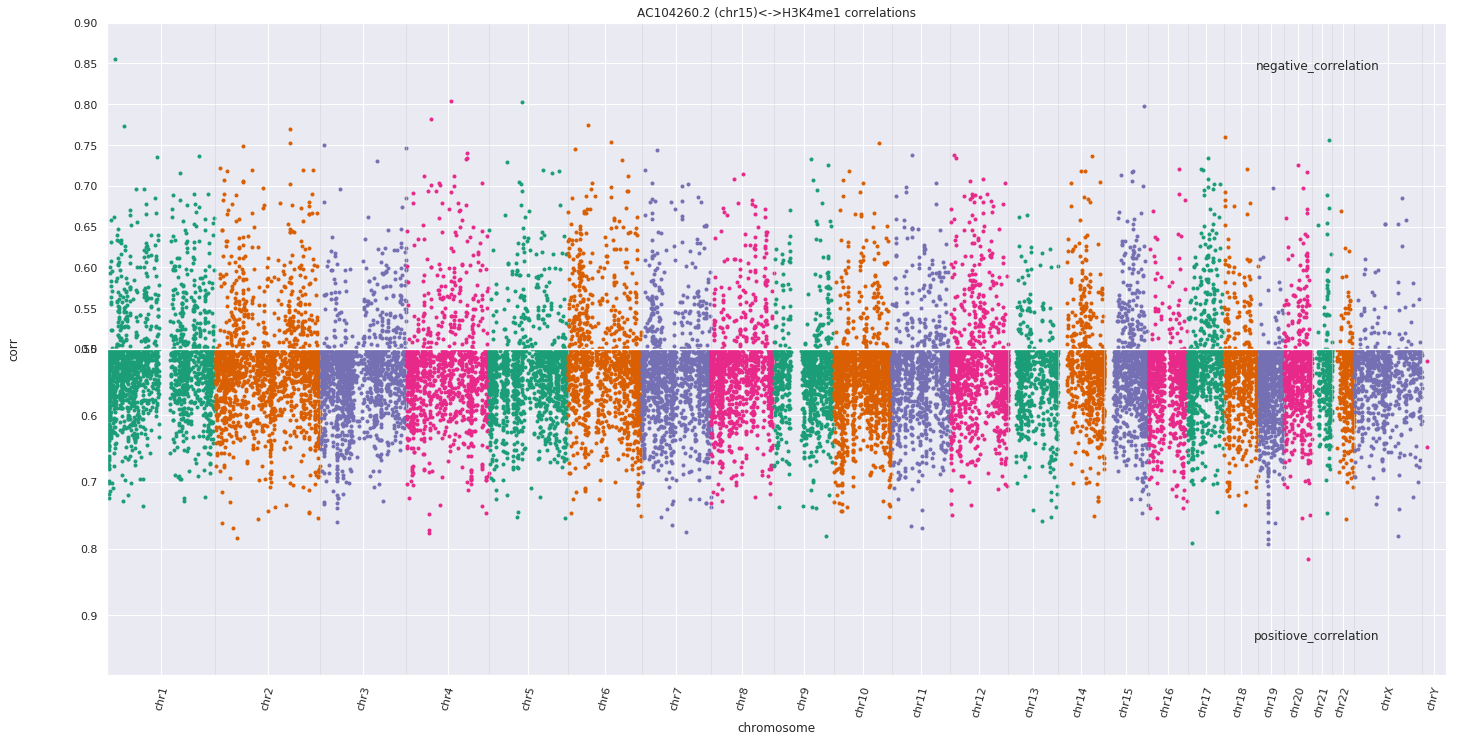

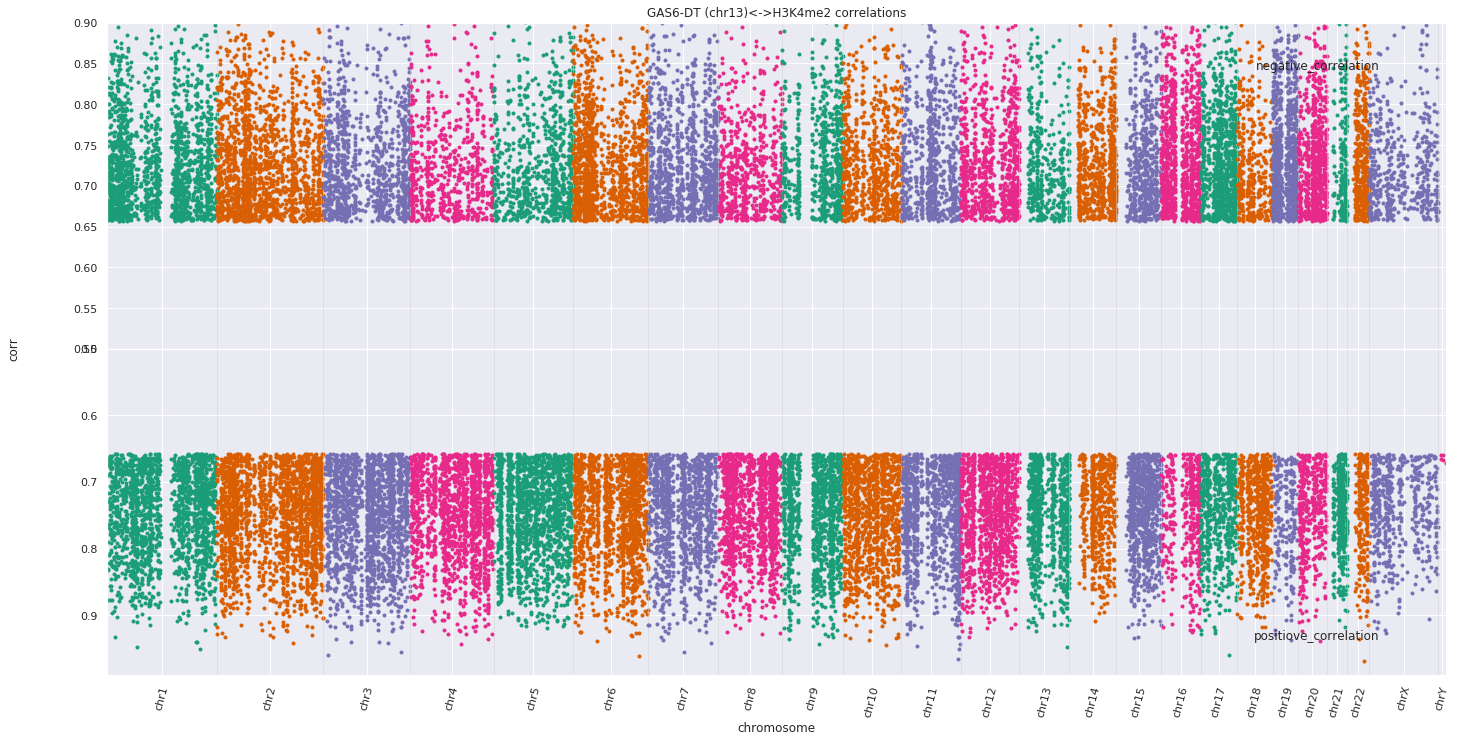

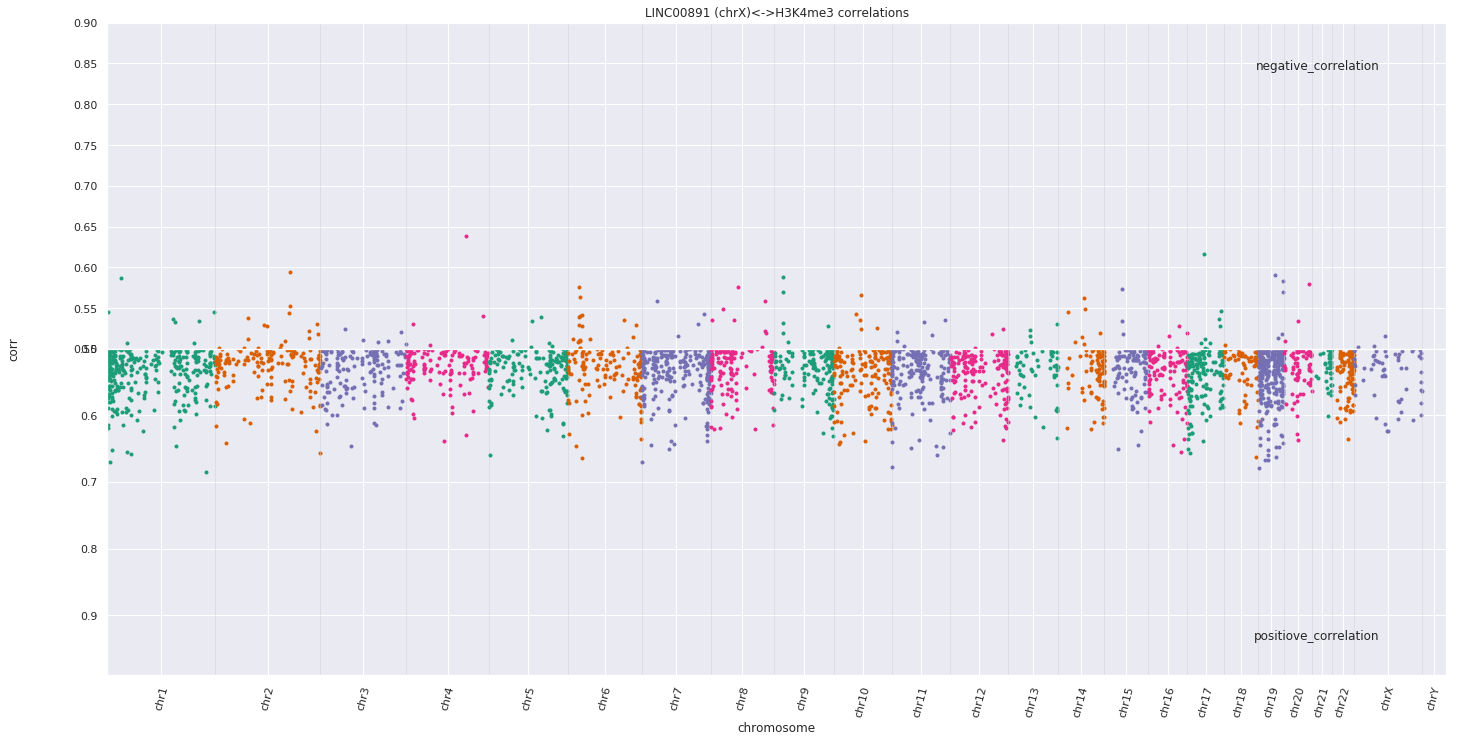

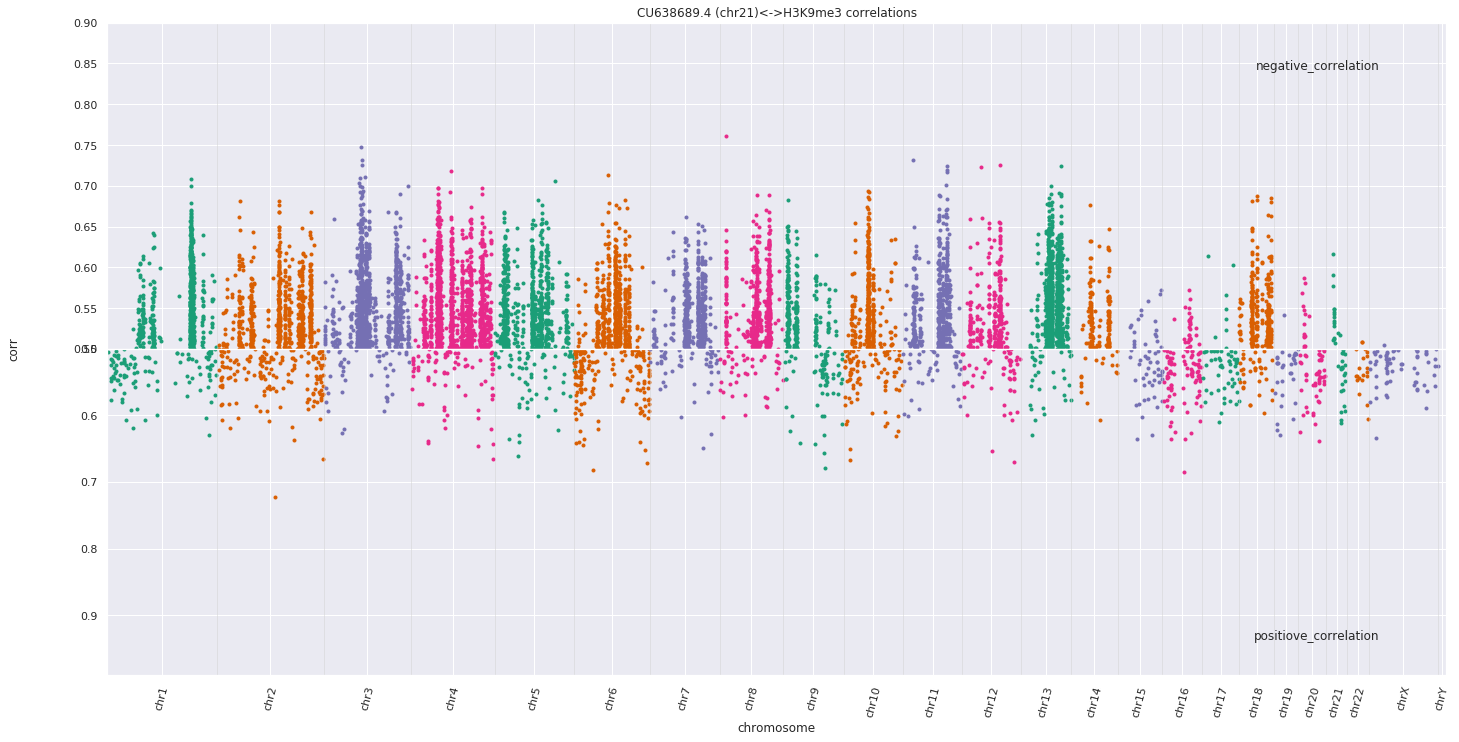

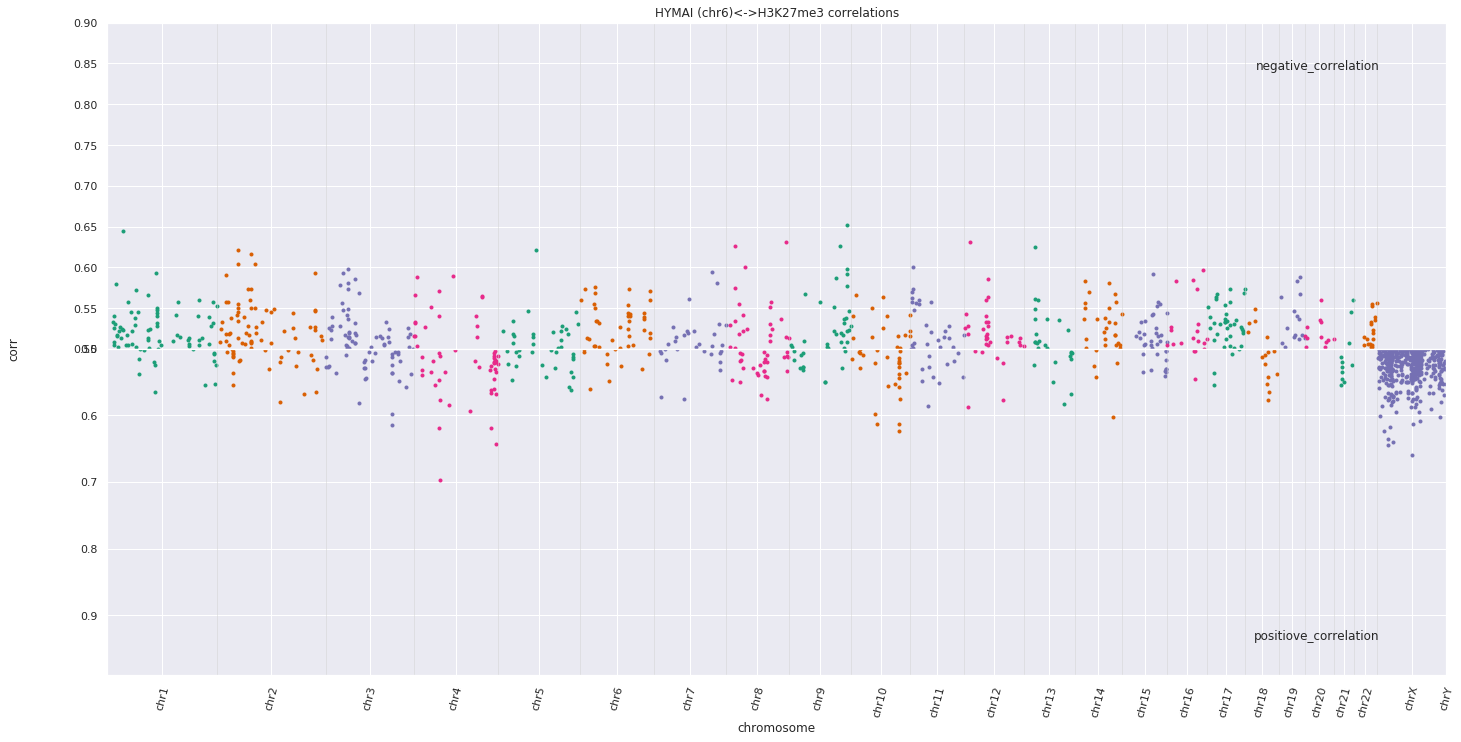

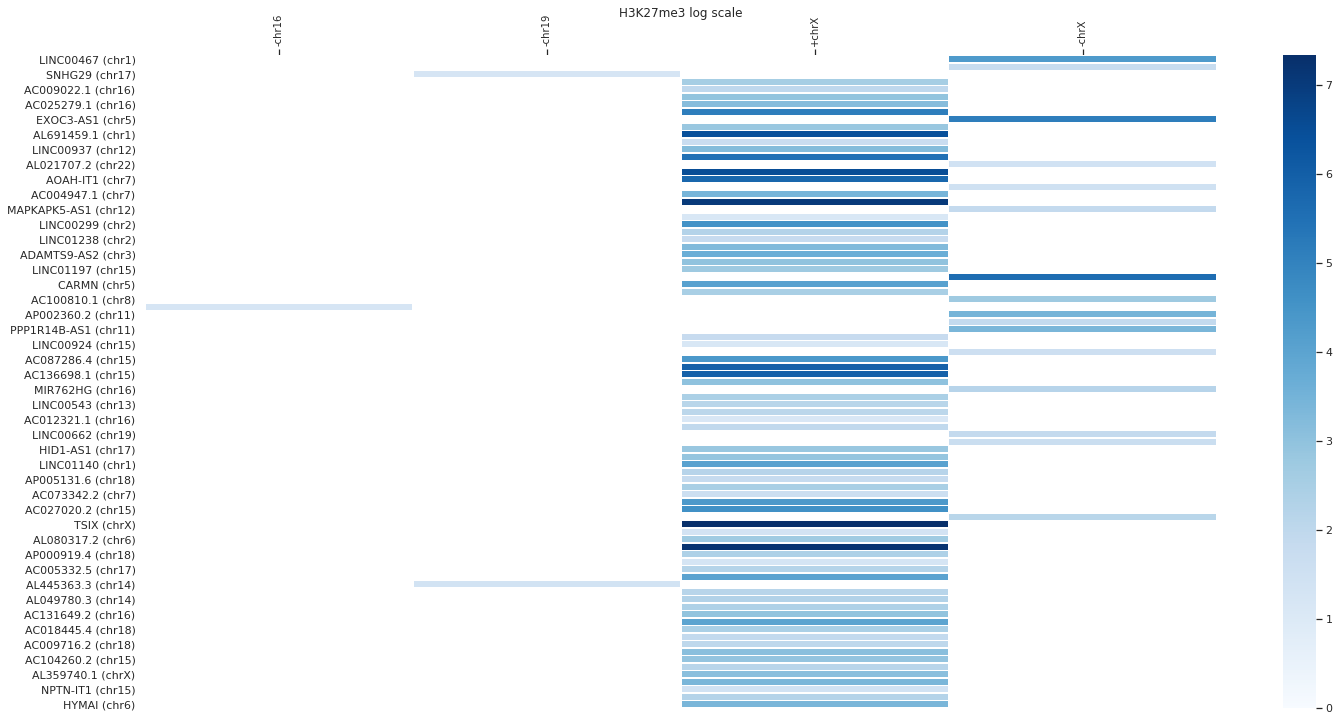

In [116]:
for target in targets:
    if target[0] in localization:
        print(target[0])
        dict_for_df = {}
        for lncRNA_id, data in localization[target[0]].items():
            tmp = OrderedDict(chroms)
            for s in data:
                sign = s[0]
                lncRNA = s[1]
                for сhr_name, chr_data in s[2].items():
                    tmp[sign + сhr_name] = chr_data[1][0] 
            manh_plot(target[0], lncRNA_id, lncRNA, "../all_marks/plots/distributions/" + target[0] + "/" + lncRNA  + "_(" + str(lncRNA_chrs[lncRNA_id]) + ")" + ".png")       
            dict_for_df[lncRNA + " (" + str(lncRNA_chrs[lncRNA_id]) + ")"] = list(tmp.values())

        df = pd.DataFrame.from_dict(dict_for_df, columns=chroms.keys(), orient="index")
        df = df.loc[:, (df != 0).any(axis=0)]
        
        plt.figure()
        sns.set(rc={'figure.figsize':(2,4)})
        from matplotlib import rcParams
        rcParams['figure.figsize'] = 6, 24
        mask = np.zeros_like(df)
        mask[df.values == 0] = True
        with sns.axes_style("white"):
            if target[0] == "H3K27me3" or target[0] == "H3K9me3":
                df = np.log(df + 1)
            ax = sns.heatmap(df, mask=mask, linewidths=.5, cmap=plt.get_cmap("Blues"))

        ax.xaxis.set_ticks_position('top')
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 10)
        plt.title(target[0] + (" log scale" if target[0] == "H3K27me3" or target[0] == "H3K9me3" else ""), y = 1.05)

        fig = ax.get_figure()
        #fig.patch.set_alpha(0)
        fig.savefig("../all_marks/plots/distributions/" + target[0] + "_lncRNAs_chroms_distribution.png")

In [105]:
def manh_plot(target, lncRNA_id, name, plot_name):
    print(target + " " + lncRNA_id + " " + name + " " + plot_name)
    rcParams['figure.figsize'] = 24, 12
    peaks_p_np, peaks_m_np = get_data_for_manhettan_plot(target, lncRNA_id)#TTTY10
    manhattan(     np.array([abs(p) for p in peaks_m_np[:, 3]]), peaks_m_np[:, 4], peaks_m_np[:, 0].astype(str), 'negative_correlation',
                   p2=peaks_p_np[:, 3], pos2=peaks_p_np[:, 4], chr2=peaks_p_np[:, 0].astype(str), label2='positiove_correlation',
                   plot_type='inverted',
                   title=name + " (" + str(lncRNA_chrs[lncRNA_id]) + ")" + '<->' + target + ' correlations',
                   chrs_plot=sorted(['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY'], key=sort_chroms),
                   xlabel='chromosome',
                   ylabel='corr',
                   cut=0.5,
                   lines= [],
                   top1 = 0.9,
                   top2 = 0.99,
                   colors = colors,
                   scaling = 'none',
                   plot_name = plot_name)

H3K27ac ENSG00000175061 SNHG29 test


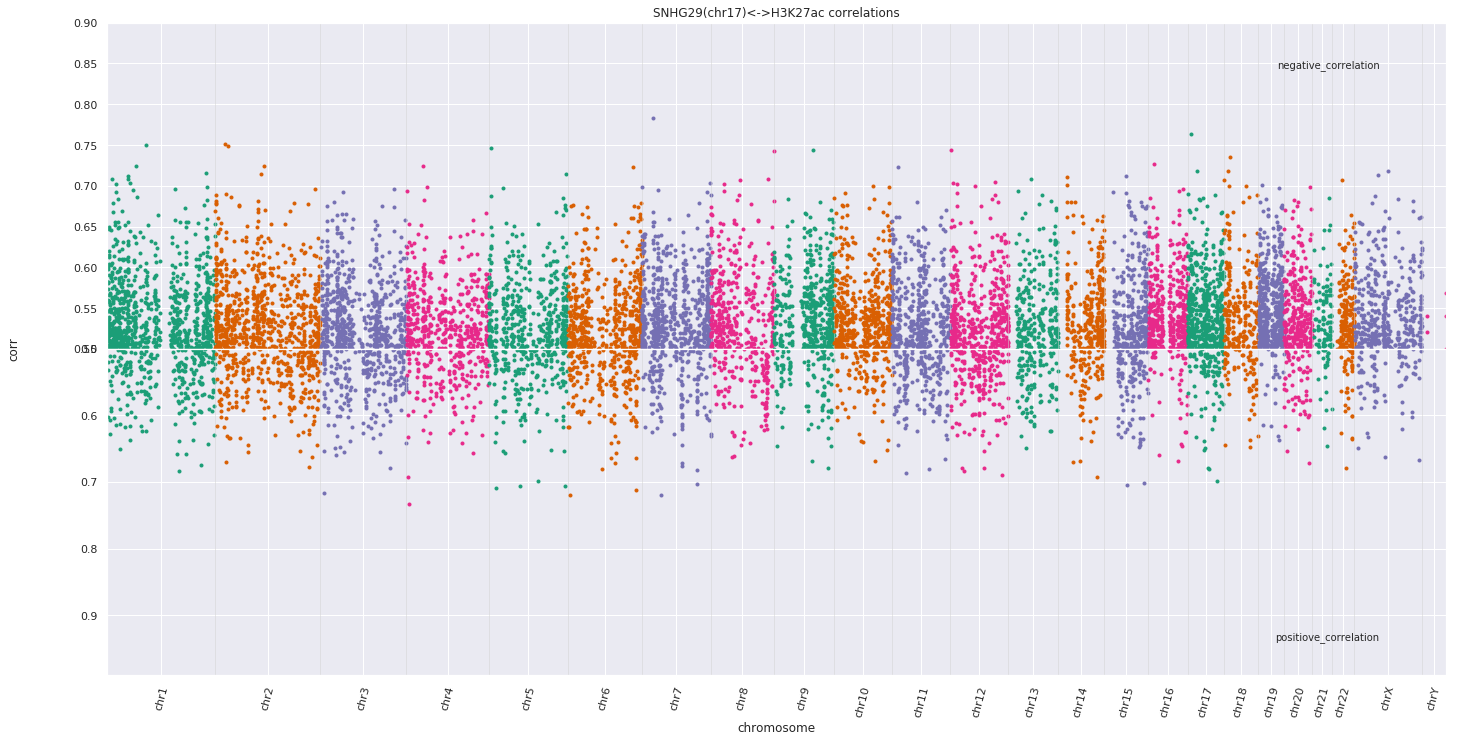

In [104]:
manh_plot("H3K27ac", "ENSG00000175061", "SNHG29", "test")

In [4]:
def fisher_by_rna(gene_id, corr, all_peaks):
    res = defaultdict(list)
    
    gene_name = ""
    
    nonzero_corrs = corr[np.nonzero(corr)[0]]
    nonzero_peaks = ["peak_" + str(i) for i in np.nonzero(corr)[0]]
    df = pd.DataFrame(list(zip(nonzero_peaks, nonzero_corrs)), columns = ['peaks', 'corrs'])
                
    peaks = all_peaks[all_peaks[3].isin(nonzero_peaks)]
    peaks = pd.merge(peaks, df, how='inner', left_on=3, right_on='peaks')[[0, 1, 2, 'corrs']]
    peaks = peaks[peaks[0].isin(["chr" + str(i) for i in range(1, 23)] + ["chrX", "chrY"])]
                
    peaks_by_chrs_p_corr = peaks[peaks['corrs'] > 0].groupby([0]).count().sort_values([0], ascending=False)
    peaks_count_p_corr = pd.DataFrame({"chr": peaks_by_chrs_p_corr.index, 'peaks_count': peaks_by_chrs_p_corr[1].tolist()}, index=[sort_chroms(c) for c in peaks_by_chrs_p_corr.index])
    peaks_count_p_corr = peaks_count_p_corr.sort_index()
    tmp = fisher_by_chroms(peaks_count_p_corr, all_peaks)
    if tmp:
        gene_name = get_gene_name(gene_id)
        res[gene_id].append(("+", gene_name, tmp))
    
    peaks_by_chrs_m_corr = peaks[peaks['corrs'] < 0].groupby([0]).count().sort_values([0], ascending=False)
    peaks_count_m_corr = pd.DataFrame({"chr": peaks_by_chrs_m_corr.index, 'peaks_count': peaks_by_chrs_m_corr[1].tolist()}, index=[sort_chroms(c) for c in peaks_by_chrs_m_corr.index])
    peaks_count_m_corr = peaks_count_m_corr.sort_index()
    tmp = fisher_by_chroms(peaks_count_m_corr, all_peaks)
    if tmp:
        if not gene_name:
            gene_name = get_gene_name(gene_id)
        res[gene_id].append(("-", gene_name, tmp))
    if res:
        print(res)
    return res

In [12]:
#peaks_count_p_corr
def fisher_by_chroms(df, all_peaks):
    chroms = df['chr'].tolist()
    res = {}
    for c in chroms:
        TP = int(df[df['chr'] == c]['peaks_count'])
        if TP >= 1000:
            FP = df[df['chr'] != c]['peaks_count'].sum()
            FN = all_peaks[all_peaks[0] == c].shape[0] - TP
            TN = all_peaks[all_peaks[0].isin(chroms)].shape[0] - all_peaks[all_peaks[0] == c].shape[0] - FP
            f = fisher_exact([[TP, FP], [FN, TN]], alternative="greater")
            if f[1] < 0.05 and f[0] >= 2:
                res[c] = (TP, fisher_exact([[TP, FP], [FN, TN]], alternative="greater"))
            
    return res

In [ ]:
#===================================================================================================================================

In [5]:
def get_data_for_manhettan_plot(target, gene_id):
    
    peaks = pd.read_csv("/data/mazurovev/all_marks/" + target + "/merged_peaks_first_in_biosample.bed", sep="\t", header=None)
    if(target == 'methylation'):
        for i in range(0, 19):
            with h5py.File("/data/mazurovev/all_marks/" + target + "/lncRNA_Peaks_corrs/lncRNA_Peaks_Correlations_corrected_non_zero_" + str(i) + ".hdf5", 'r') as f:
                lncRNAs = list(f['lncRNAs_names'][:])
                if gene_id in lncRNAs:
                    corrs = f['corrs_matrix'][lncRNAs.index(gene_id), :]
                    break
                else:
                    print("not in " + str(i) + " chunk")
    else:
        with h5py.File("/data/mazurovev/all_marks/" + target + "/lncRNA_Peaks_corrs/lncRNA_Peaks_Correlations_corrected_non_zero.hdf5", 'r') as f:
            lncRNAs = list(f['lncRNAs_names'][:])
            corrs = f['corrs_matrix'][lncRNAs.index(gene_id), :]
        
    nonzero_corrs = corrs[np.nonzero(corrs)[0]]
    nonzero_peaks = ["peak_" + str(i) for i in np.nonzero(corrs)[0]]
    df = pd.DataFrame(list(zip(nonzero_peaks, nonzero_corrs)), columns = ['peaks', 'corrs']) 
    
    peaks = peaks[peaks[3].isin(nonzero_peaks)]
    peaks = pd.merge(peaks, df, how='inner', left_on=3, right_on='peaks')[[0, 1, 2, 'corrs']]
    peaks = peaks[peaks[0].isin(["chr" + str(i) for i in range(1, 23)] + ["chrX", "chrY"])]
    
    peaks['center'] = peaks[1] + np.ceil((peaks[2] - peaks[1])/2)  # метилирование?
    peaks_p = peaks[peaks['corrs'] > 0]
    peaks_m = peaks[peaks['corrs'] < 0]
    
    for chrom in set(['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY']).difference(set(peaks_p[0])):
        peaks_p = peaks_p.append({0: chrom, 1:0, 2:0, 'corrs':0, 'center':0}, ignore_index=True)
    
    for chrom in set(['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY']).difference(set(peaks_m[0])):
        peaks_m = peaks_m.append({0: chrom, 1:0, 2:0, 'corrs':0, 'center':0}, ignore_index=True)
        
    return peaks_p.to_numpy(), peaks_m.to_numpy()

[10321.0 180896.0 181499.0 ... 248887833.0 248945556.0 248946050.0]
[249352321.0 249366190.0 249385804.0 ... 490966958.0 491008069.0
 491065423.0]
[491117143.0 491139065.0 491261548.0 ... 689205369.0 689215284.0
 689223543.0]
[689374958.0 689583645.0 689706972.0 ... 879058420.0 879205024.0
 879346374.0]
[879577708.0 879579328.0 879590558.0 ... 1060402135.0 1060402870.0
 1060555496.0]
[1060861567.0 1060865497.0 1060868510.0 ... 1230911423.0 1230911909.0
 1231069322.0]
[1231140677.0 1231184972.0 1231189637.0 ... 1390266180.0 1390277859.0
 1390281011.0]
[1390487926.0 1390507437.0 1390554458.0 1390558785.0 1390604188.0
 1390620345.0 1390626950.0 1390655512.0 1390687760.0 1390715210.0
 1390755181.0 1390826314.0 1390846017.0 1390855204.0 1390906392.0
 1390953801.0 1390989952.0 1391031836.0 1391032312.0 1391068267.0
 1391150435.0 1391152798.0 1391230906.0 1391234798.0 1391268194.0
 1391376133.0 1391377894.0 1391388992.0 1391419583.0 1391424094.0
 1391434151.0 1391443754.0 1391445859.0 1391541

0

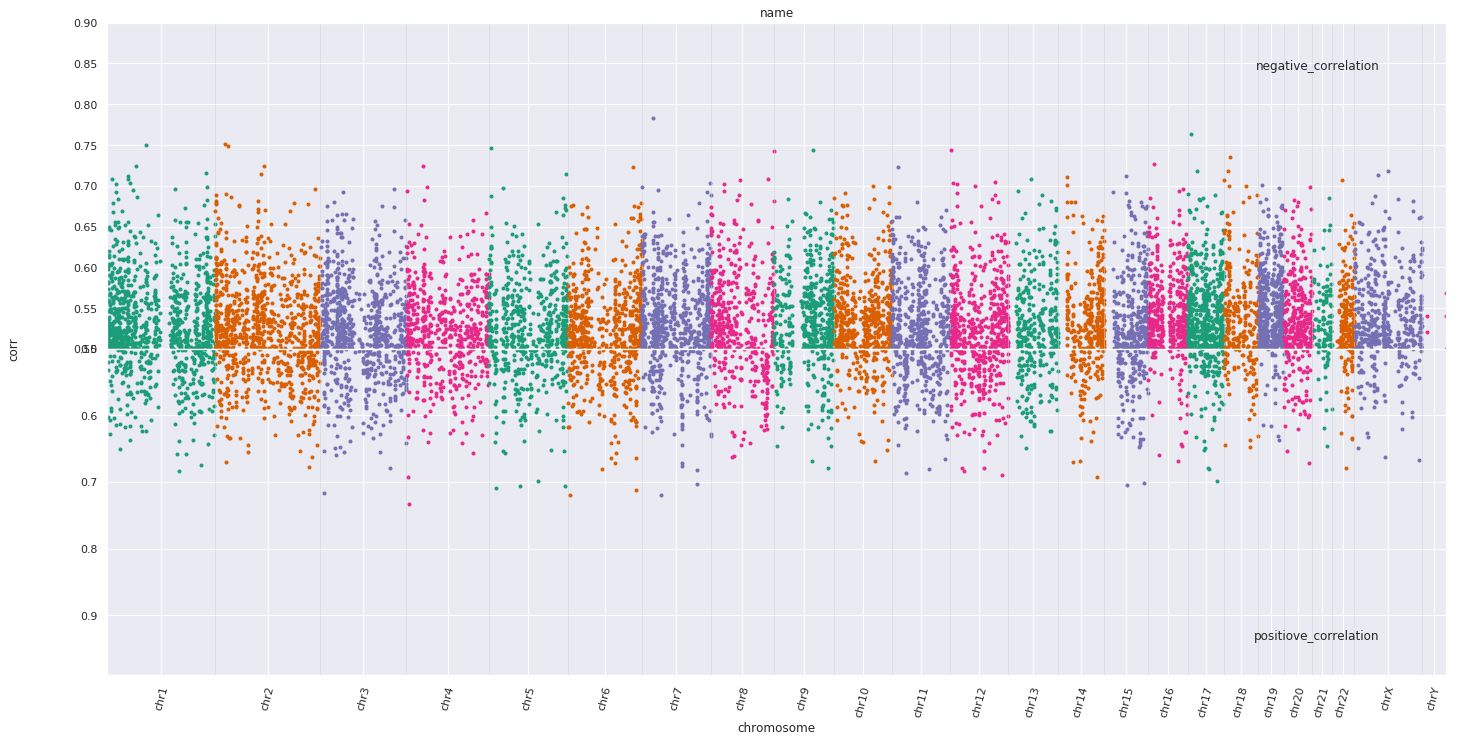

In [22]:
    rcParams['figure.figsize'] = 24, 12
    peaks_p_np, peaks_m_np = get_data_for_manhettan_plot("H3K27ac", "ENSG00000175061")
    manhattan(     np.array([abs(p) for p in peaks_m_np[:, 3]]), peaks_m_np[:, 4], peaks_m_np[:, 0].astype(str), 'negative_correlation',
                   p2=peaks_p_np[:, 3], pos2=peaks_p_np[:, 4], chr2=peaks_p_np[:, 0].astype(str), label2='positiove_correlation',
                   plot_type='inverted',
                   title='name',
                   chrs_plot=sorted(['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY'], key=sort_chroms),
                   xlabel='chromosome',
                   ylabel='corr',
                   cut=0.5,
                   lines= [],
                   top1 = 0.9,
                   top2 = 0.99,
                   colors = colors,
                   scaling = 'none',
                   plot_name = "s")

In [11]:
def sort_chroms(chrom):
    return int(chrom.split('chr')[1] if chrom.split('chr')[1]!='X' and chrom.split('chr')[1] != 'Y' else 40 if chrom.split('chr')[1]=='X' else 41)

In [24]:
t = {"label": "chr1", "value": 3456}

In [26]:
next(iter(t.values()))

'chr1'

In [21]:
def sorted_nicely( l ):
    """ Sort the given iterable in the way that humans expect."""
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(l, key = alphanum_key)

def manhattan(p1, pos1, chr1, label1,
               p2=None, pos2=None, chr2=None, label2=None,
               plot_type='single',
               chrs_plot=None, chrs_names=None,
               cut = 2,
               colors = ['k', '0.5'],
               title='Title',
               xlabel='chromosome',
               ylabel='-log10(p-value)',
               top1 = 0,
               top2 = 0,
               lines = [10, 15],
               lines_colors = ['g', 'r'],
               zoom = None,
               scaling = '-log10', plot_name=""):
    '''
    Static Manhattan plot
    :param p1: p-values for the top panel
    :param pos1: positions
    :param chr1: chromosomes numbers
    :param label1: label
    :param p2: p-values fpeaks_p_np, peaks_m_np = get_data_for_manhettan_plot("H3K9me3", 'ENSG00000225470')#FTX
manhattan(     np.array([abs(p) for p in peaks_m_np[:, 3]]), peaks_m_np[:, 4], peaks_m_np[:, 0].astype(str), 'peaks_m',
               p2=peaks_p_np[:, 3], pos2=peaks_p_np[:, 4], chr2=peaks_p_np[:, 0].astype(str), label2='peaks_p',
               plot_type='inverted',
               title='FTX<->H3K9me3 correlations',
               chrs_plot=sorted(['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY'], key=sort_chroms),
               xlabel='chromosome',
               ylabel='corr',
               cut=0.45,
               lines= [],
               top1 = 0.8,
               top2 = 0.8,
               colors = colors,
               scaling = 'none')or the bottom panel
    :param pos2: positions
    :param chr2: chromosomes numbers
    :param label2: label
    :param type: Can be 'single', 'double' or 'inverted'
    :param chrs_plot: list of chromosomes that should be plotted. If empty [] all chromosomes will be plotted
    :param cut: lower cut (default 2)
    :param colors: sequence of colors (default: black/gray)
    :param title: defines the title of the plot
    :param xlabel: defines the xlabel of the plot
    :param ylabel: defines the ylabel of the plot
    :param top: Defines the upper limit of the plot. If 0, it is detected automatically.
    :param lines: Horizontal lines to plot.
    :param lines_colors: Colors for the horizontal lines.
    :param zoom: [chromosome, position, range] Zooms into a region.
    :param scaling: '-log10' or 'none' (default -log10)
    :return:
    '''

    # Setting things up
    shift=np.array([0.0])
    plt.clf()

    # If chrs_plot is empty, we need to generate a list of chromosomes
    if chrs_plot is None:
        chrs_list = np.unique(chr1)
        if isinstance(chrs_list[0], str):
            chrs_list = sorted_nicely(chrs_list)
        else:
            chrs_list.sort()
    else:
        chrs_list = chrs_plot


    # If chrs_names is empty, we need to generate a list of names for chromosomes
    if chrs_names is None:
        chrs_names = [str(chrs_list[i]) for i in range(len(chrs_list))]

    plot_positions = False
    if len(chrs_list) == 1:
        plot_positions = True

    
    for ii, i in enumerate(chrs_list):
        if plot_type != 'single':
            ax1 = plt.subplot(2,1,1)
        else:
            plt.subplot(1,1,1)
        # print(i)
        filt = np.where(chr1==i)[0]
        x = shift[-1]+pos1[filt]
        print(x)
        if scaling=='-log10':
            y = -np.log10(p1[filt])
        elif scaling=='none':
            y = p1[filt]
        else:
            raise ValueError('Wrong "scaling" mode. Choose between "-log10" and "none"')
        plt.plot(x[y>cut], y[y>cut], '.', color=colors[ii % len(colors)])
        shift_f = np.max(x)

        if zoom is not None:
            if zoom[0] == i:
                zoom_shift = zoom[1] + shift[-1]

        if plot_type != 'single':
            ("print pos2:")
            plt.subplot(2,1,2)#, sharex=ax1)
            filt = np.where(chr2==i)[0]
            x = shift[-1]+pos2[filt]
            if scaling=='-log10':
                y = -np.log10(p2[filt])
            elif scaling=='none':
                y = p2[filt]
            else:
                raise ValueError('Wrong "scaling" mode. Choose between "-log10" and "none"')
            plt.plot(x[y>cut], y[y>cut], '.', color=colors[ii % len(colors)])
            shift_m = np.max(x)
        else:
            shift_m = 0

        shift = np.append(shift, np.max([shift_f, shift_m]))

        if plot_type != 'single':
            plt.subplot(2,1,1)
        else:
            plt.subplot(1,1,1)
        plt.plot([shift[-1], shift[-1]], [0, 1000], '-k', lw=0.5, color='lightgray')
        plt.xlim([0, shift[-1]])

        if plot_type != 'single':
            plt.subplot(2,1,2)
            plt.plot([shift[-1], shift[-1]], [0, 1000], '-k', lw=0.5, color='lightgray')
            plt.xlim([0, shift[-1]])
        # print(shift)

    # Defining top boundary of a plot
    if top1 == 0:
        if plot_type != 'single':
            if scaling == '-log10':
                top1 = np.ceil(np.max([np.max(-np.log10(p1)), np.max(-np.log10(p2))]))
            elif scaling == 'none':
                top1 = np.ceil(np.max([np.max(p1), np.max(p2)]))
            else:
                raise ValueError('Wrong "scaling" mode. Choose between "-log10" and "none"')
        else:
            if scaling == '-log10':
                top1 = np.ceil(np.max(-np.log10(p1)))
            elif scaling == 'none':
                top1 = np.ceil(np.max(p1))
            else:
                raise ValueError('Wrong "scaling" mode. Choose between "-log10" and "none"')


    if top2 == 0:
        if plot_type != 'single':
            top2 = top1

    # Setting up the position of labels:
    shift_label = shift[-1]
    shift = (shift[1:]+shift[:-1])/2.
    labels = chrs_names

    # Plotting horizontal lines
    for i, y in enumerate(lines):
        if plot_type != 'single':
            plt.subplot(2,1,1)
            plt.plot([0, shift_label], [y, y], color = lines_colors[i])
            plt.subplot(2,1,2)
            plt.plot([0, shift_label], [y, y], color = lines_colors[i])
        else:
            plt.subplot(1,1,1)
            plt.plot([0, shift_label], [y, y], color = lines_colors[i])

    if plot_type != 'single':
        plt.subplot(2,1,1)
        if not plot_positions:
            plt.xticks(shift, labels, rotation=75)
        plt.ylim([cut, top1])
    else:
        plt.subplot(1,1,1)
        plt.ylim([cut, top1])
        plt.xticks(rotation=75)
    plt.title(title)
    if plot_type != 'single':
        plt.setp(plt.gca().get_xticklabels(), visible=False)
        if not plot_positions:
            plt.xticks(shift, rotation=75)
    else:
        if not plot_positions:
            plt.xticks(shift, labels, rotation=75)

    plt.text(shift_label*0.95,top1*0.95,label1,#bbox=dict(boxstyle="round", fc="1.0"),
            verticalalignment='top', horizontalalignment='right')

    if plot_type != 'single':
        plt.subplot(2,1,2)
        plt.ylim([cut, top2])
        if plot_type == 'inverted':
            plt.gca().invert_yaxis()
            #plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_func))
        if not plot_positions:
            plt.xticks(shift, labels, rotation=75)
        if plot_type == 'inverted':
            plt.text(shift_label*0.95,top2*0.95,label2,#bbox=dict(boxstyle="round", fc="1.0"),
                verticalalignment='bottom', horizontalalignment='right')
        else:
            plt.text(shift_label*0.95,top2*0.95,label2,#bbox=dict(boxstyle="round", fc="1.0"),
                verticalalignment='top', horizontalalignment='right')
        plt.ylabel(ylabel)
        plt.gca().yaxis.set_label_coords(-0.065,1.)
        plt.xlabel(xlabel)
        # plt.tight_layout(hspace=0.001)
        plt.subplots_adjust(hspace=0.00)
    else:
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)

    if zoom is not None:
        if plot_type != 'single':
            plt.subplot(2,1,1)
            plt.xlim([zoom_shift-zoom[2], zoom_shift+zoom[2]])
            plt.subplot(2,1,2)
            plt.xlim([zoom_shift-zoom[2], zoom_shift+zoom[2]])
        else:
            plt.subplot(1,1,1)
            plt.xlim([zoom_shift-zoom[2], zoom_shift+zoom[2]])
    plt.savefig(plot_name)
    return 0

In [119]:
def format_func(value, tick_number):
    return "-" + str(value)

In [14]:
def get_gene_name(gene_id):
    mg = mygene.MyGeneInfo()
    out = mg.querymany([gene_id], scopes='ensembl.gene', fields="symbol", species='human', 
                           returnall=True, as_dataframe=True)
    with_symbol = out['out']
    del with_symbol.index.name
    with_symbol['ensembl_id'] = with_symbol.index
    if 'symbol' in with_symbol.columns:
        with_symbol = with_symbol.reset_index()[['ensembl_id', 'symbol']]
        with_symbol = with_symbol[with_symbol['symbol'].notnull()]
        return with_symbol.loc[0]['symbol']
    else:
        return None

In [ ]:
#1)X хромосома: если есть, то обычно только один знак строго
#2)Взаимодействие пиков X и Y хромосом: обычно они взаимоисключающие и разного знака, а иногда просто только одного знака
#)Посмотреть на конкретные цифры экспрессии/сигала (в каких тканях) + в каких местах(сделать GO?)
#)Доработать метод для выбрасывания лишних пиков?
#)Хотим узнать если ли у меток пересечения по нкРНК, по хромосомам
#)Если пересекаются, то в одинаковых ли местах пики?(и связаны ли они как-нибудь? GO может?)
#)Нарисовать хитмап +
#)Пересечь с кластерами